In [2]:
from Bio import SeqIO
import pandas as pd
import numpy as np

from genominterv.remapping import remap
from genominterv.remapping import interval_distance, genomic
from genominterv.remapping import remap_interval_data
import seaborn as sns

## loading eigenvectors using kasper code

In [3]:
def parse_compartment_data(file_name):
    e1_100kb = pd.read_csv(file_name)

       
    # remove na (experiment)
    e1_100kb.dropna(inplace=True)
    
    e1_100kb['start'] = [i*100_000 for i in range(e1_100kb.index.size)]
    e1_100kb['end'] = e1_100kb.start + 100_000
    e1_100kb['sign'] = np.sign(e1_100kb.e1)
    e1_100kb['segment_id'] = ((e1_100kb.sign.shift() != e1_100kb.sign)).cumsum()
    
    comp = e1_100kb.groupby('segment_id', as_index=False).agg(dict(
         e1=['mean', 'sum'], 
         start='min', 
         end='max', 
         segment_id='mean', 
         sign='mean'
    ))
    comp.columns = ['_'.join(col).strip() for col in comp.columns.values]
    comp = comp.rename(
        columns={'start_min':'start',
                 'end_max':'end', 
                 'segment_id_mean':'segment_id', 
                 'sign_mean':'sign'}
    )
    comp['comp'] = ['A' if x > 0 else 'B' for x in comp.sign]
    comp = comp.reset_index()
    comp['chrom'] = 'chrX'
    
    _comp = comp.copy()
    for i in range(1, _comp.index.size-1):
        if np.isnan(_comp.loc[i-1, 'e1_mean']):
            _comp.loc[i, 'start'] = np.nan
        if np.isnan(_comp.loc[i+1, 'e1_mean']):
            _comp.loc[i, 'end'] = np.nan
    _comp = _comp.loc[~_comp.e1_mean.isnull(), :]
    _comp = _comp.reset_index()
    compartment_edges = pd.concat([_comp.start, _comp.end]).sort_values().unique()
    
    compartments = comp.loc[~comp.e1_mean.isnull()].copy()
    compartments['start'] = compartments.start.astype(int)
    compartments['end'] = compartments.end.astype(int)

    return compartments, compartment_edges

def edge_segments(compartment_edges, flank):
    compartment_edge_segm = pd.DataFrame(np.column_stack((compartment_edges, compartment_edges+flank)), columns=['start', 'end'])
    compartment_edge_segm['chrom'] = 'chrX'
    return compartment_edge_segm

In [4]:
import os

# Load data
eigentrack_dir = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/eigentracks"
eigentrack_files = [
    f for f in os.listdir(eigentrack_dir) if f.endswith("_10Mb.csv")
]

comps_dict = {}
edges_dict = {}
generated_comps=[]
generated_edges=[]
a_and_b_comps = []

for filename in eigentrack_files:
    filepath = os.path.join(eigentrack_dir, filename)
    base = os.path.splitext(filename)[0]
    comps_var = f"{base}_comps"
    edges_var = f"{base}_edges"
    comps, edges = parse_compartment_data(filepath)
    comps_dict[comps_var] = comps
    edges_dict[edges_var] = edges
    generated_comps.append(comps_var)
    generated_edges.append(edges_var)

print("Generated variable names:", generated_comps)
print("Generated variable names:", generated_edges)

for edge_var in generated_edges:
    # Get the numpy array of edges from the dictionary
    edges = edges_dict[edge_var]
    
    # Create the DataFrame using edge_segments with flank=1
    seg_name = f"{edge_var}_interval"
    seg_df = edge_segments(edges, 1)
    #print(f"Created: {seg_name}")

    # Merge compartment assignment
    comps_var = edge_var.replace("_edges", "_comps")
    if comps_var in comps_dict:
        comps_df = comps_dict[comps_var]
        
        comp_df = pd.DataFrame({
            'comp': comps_df['comp'].reset_index(drop=True),
            'start': seg_df['start'].reset_index(drop=True),
            'end': seg_df['end'].reset_index(drop=True),
            'chrom': seg_df['chrom'].reset_index(drop=True)
        })

        # Save full merged comp_df
        comp_full_name = f"{edge_var}_interval_comp"
            # Save combined A and B compartments
        comp_AB_name = f"{edge_var}_AB"
        globals()[comp_AB_name] = comp_df
        a_and_b_comps.append(comp_AB_name)

        #print(f"Created: {comp_full_name}")

        # Split into compartments A and B
        comp_A = comp_df[comp_df['comp'] == 'A'].reset_index(drop=True)
        comp_B = comp_df[comp_df['comp'] == 'B'].reset_index(drop=True)

        # Save A and B splits as new variables
        comp_A_name = f"{edge_var}_A"
        comp_B_name = f"{edge_var}_B"
        globals()[comp_A_name] = comp_A
        globals()[comp_B_name] = comp_B
        a_and_b_comps.append(comp_A_name)
        a_and_b_comps.append(comp_B_name)
        
        #print(f"Created: {edge_var}_A and {edge_var}_B")

print("Generated compartment A and B variables:", a_and_b_comps)

#print(sperm_e1_100kb_10Mb_edges_A.head())

print(globals()[comp_AB_name].head())

Generated variable names: ['sperm_e1_100kb_10Mb_comps', 'round_spermatid_e1_100kb_10Mb_comps', 'pachytene_spermatocyte_e1_100kb_10Mb_comps', 'spermatogonia_e1_100kb_10Mb_comps', 'fibroblast_e1_100kb_10Mb_comps']
Generated variable names: ['sperm_e1_100kb_10Mb_edges', 'round_spermatid_e1_100kb_10Mb_edges', 'pachytene_spermatocyte_e1_100kb_10Mb_edges', 'spermatogonia_e1_100kb_10Mb_edges', 'fibroblast_e1_100kb_10Mb_edges']
Generated compartment A and B variables: ['sperm_e1_100kb_10Mb_edges_AB', 'sperm_e1_100kb_10Mb_edges_A', 'sperm_e1_100kb_10Mb_edges_B', 'round_spermatid_e1_100kb_10Mb_edges_AB', 'round_spermatid_e1_100kb_10Mb_edges_A', 'round_spermatid_e1_100kb_10Mb_edges_B', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_AB', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_A', 'pachytene_spermatocyte_e1_100kb_10Mb_edges_B', 'spermatogonia_e1_100kb_10Mb_edges_AB', 'spermatogonia_e1_100kb_10Mb_edges_A', 'spermatogonia_e1_100kb_10Mb_edges_B', 'fibroblast_e1_100kb_10Mb_edges_AB', 'fibroblast_e1_1

## load cpsislands

In [5]:
import pandas as pd
file_path = "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/data/macaca/cpgIslandExt.txt"
# Load directly from compressed file
df = pd.read_csv(file_path, sep='\t', header=None)

# Assign column names
df.columns = [
    "bin",
    "chrom",
    "chromStart",
    "chromEnd",
    "name",
    "length",
    "cpgNum",
    "gcNum",
    "perCpg",
    "perGc",
    "obsExp"
]

# Show first few rows
print(df.head())

   bin chrom  chromStart  chromEnd      name  length  cpgNum  gcNum  perCpg  \
0  585  chr1       26177     26863   CpG: 77     686      77    446    22.4   
1  585  chr1       56871     57183   CpG: 33     312      33    199    21.2   
2  585  chr1       71413     72476   CpG: 94    1063      94    708    17.7   
3  585  chr1       82173     83468  CpG: 153    1295     153    899    23.6   
4  585  chr1       90820     92065  CpG: 138    1245     138    872    22.2   

   perGc  obsExp  
0   65.0    1.12  
1   63.8    1.04  
2   66.6    0.80  
3   69.4    0.99  
4   70.0    0.91  


UCSC cpgIslandExt Table: Column Descriptions
Column Name	Example	Description
bin	585	UCSC internal field for efficient querying (can usually be ignored).
chrom	chr1	Chromosome name (e.g., chr1, chrX).
chromStart	26177	Start coordinate of the CpG island (0-based, inclusive).
chromEnd	26863	End coordinate of the CpG island (0-based, exclusive).
name	CpG: 77	Island identifier (often encodes CpG count).
length	686	Length of the CpG island (in bp).
cpgNum	77	Number of CpG dinucleotides in the island.
gcNum	446	Number of G or C bases in the island.
perCpg	22.4	Percentage of CpG dinucleotides relative to island length.
perGc	65.0	GC content percentage: (gcNum / length) * 100.
obsExp	1.12	Observed/expected CpG ratio (see formula below).





In [6]:
df_chrX = df[df['chrom'] == 'chrX'].reset_index(drop=True)
print(df_chrX.head())
df_chrX = df_chrX[['chrom', 'chromStart', 'chromEnd']].rename(
    columns={'chromStart': 'start', 'chromEnd': 'end'})
print(df_chrX.head())

   bin chrom  chromStart  chromEnd      name  length  cpgNum  gcNum  perCpg  \
0  585  chrX       44203     44761   CpG: 49     558      49    374    17.6   
1  585  chrX       71313     73056  CpG: 124    1743     124   1177    14.2   
2  585  chrX       75338     76415   CpG: 80    1077      80    693    14.9   
3  585  chrX       77670     78750   CpG: 68    1080      68    667    12.6   
4  585  chrX       80467     85767  CpG: 374    5300     374   3005    14.1   

   perGc  obsExp  
0   67.0    0.81  
1   67.5    0.63  
2   64.3    0.72  
3   61.8    0.66  
4   56.7    0.88  
  chrom  start    end
0  chrX  44203  44761
1  chrX  71313  73056
2  chrX  75338  76415
3  chrX  77670  78750
4  chrX  80467  85767


In [7]:
import numpy as np
import pandas as pd
from genominterv.remapping import remap_interval_data




def plot_repeat_density_vs_compartment_edge(df_repeats, df_compartment_anchors):
    """
    Remaps repeat intervals to a compartment coordinate space and returns the
    A-value and B-value groups based on signed distance logic.

    Parameters:
    - df_repeats: DataFrame of genomic intervals to remap (must have chrom/start/end).
    - df_compartment_anchors: DataFrame with compartment structure (must have chrom/start/end/comp).

    Returns:
    - A_val: DataFrame for Compartment A-assigned intervals
    - B_val: DataFrame for Compartment B-assigned intervals
    """

    # Clean and sort
    sperm_clean = df_compartment_anchors.dropna(subset=["start", "end"]).copy()
    sperm_clean["start"] = sperm_clean["start"].astype(int)
    sperm_clean["end"] = sperm_clean["end"].astype(int)
    df_repeats = df_repeats.dropna(subset=["start", "end"]).copy()
    df_repeats["start"] = df_repeats["start"].astype(int)
    df_repeats["end"] = df_repeats["end"].astype(int)

    # Sort
    sperm_clean = sperm_clean.sort_values(by=['chrom', 'start', 'end'])
    df_repeats = df_repeats.sort_values(by=['chrom', 'start', 'end'])

    # Remap
    result = remap_interval_data(df_repeats, sperm_clean, include_prox_coord=True)

    # Post-process
    result["mid"] = (result["start"] + result["end"]) / 2
    result["absmid"] = result["mid"].abs()
    for col in ["start", "end", "mid", "absmid"]:
        result[col] = result[col].replace([0.0, -0.0], np.nan)
    result = result.dropna(subset=["start", "end", "mid", "absmid", "start_prox", "end_prox"], how="any")

    # Map compartment identity
    start_to_comp = sperm_clean.drop_duplicates(subset=["start"]).set_index("start")["comp"]
    result["comp"] = result["start_prox"].map(start_to_comp)

    # Split into A and B groups based on signed start
    A_val = result[
        ((result['comp'] == 'A') & (result['start'] < 0)) |
        ((result['comp'] == 'B') & (result['start'] > 0))
    ].copy()
    B_val = result[
        ((result['comp'] == 'A') & (result['start'] > 0)) |
        ((result['comp'] == 'B') & (result['start'] < 0))
    ].copy()

    # Add abs start and label
    A_val['abs_start'] = A_val['start'].abs()
    B_val['abs_start'] = B_val['start'].abs()
    A_val['group'] = 'Compartment A'
    B_val['group'] = 'Compartment B'

    return A_val, B_val

A_val, B_val = plot_repeat_density_vs_compartment_edge( df_chrX, sperm_e1_100kb_10Mb_edges_AB)
print(A_val.head())
print(B_val.head())



     start     end  start_prox   end_prox chrom  start_orig  end_orig  \
85   15174   15388   1700000.0  1700001.0  chrX     1715175   1715389   
86   28833   29040   1700000.0  1700001.0  chrX     1728834   1729041   
87  122632  123028   1700000.0  1700001.0  chrX     1822633   1823029   
88  212345  215308   1700000.0  1700001.0  chrX     1912346   1915309   
89  358698  360438   1700000.0  1700001.0  chrX     2058699   2060439   

         mid    absmid comp  abs_start          group  
85   15281.0   15281.0    B      15174  Compartment A  
86   28936.5   28936.5    B      28833  Compartment A  
87  122830.0  122830.0    B     122632  Compartment A  
88  213826.5  213826.5    B     212345  Compartment A  
89  359568.0  359568.0    B     358698  Compartment A  
   start    end  start_prox  end_prox chrom  start_orig  end_orig      mid  \
0  44202  44760         0.0       1.0  chrX       44203     44761  44481.0   
1  71312  73055         0.0       1.0  chrX       71313     73056  72

In [8]:
ab_dfs = {name: obj for name, obj in globals().items()
          if name.endswith('_AB') and isinstance(obj, pd.DataFrame)}
remapped_simple_filter_data = {}

for name, df_anchor in ab_dfs.items():
    print(f"\nRunning on: {name}")
    try:
        A_value, B_value = plot_repeat_density_vs_compartment_edge(df_chrX, df_anchor)
        remapped_simple_filter_data[name.replace('_AB', '')] = {"A": A_value, "B": B_value}
        print(f"  A_value: {A_value.shape}, B_value: {B_value.shape}")
    except Exception as e:
        print(f"  ❌ Failed on {name}: {e}")


Running on: sperm_e1_100kb_10Mb_edges_AB
  A_value: (427, 12), B_value: (353, 12)

Running on: round_spermatid_e1_100kb_10Mb_edges_AB
  A_value: (459, 12), B_value: (317, 12)

Running on: pachytene_spermatocyte_e1_100kb_10Mb_edges_AB
  A_value: (398, 12), B_value: (356, 12)

Running on: spermatogonia_e1_100kb_10Mb_edges_AB
  A_value: (432, 12), B_value: (341, 12)

Running on: fibroblast_e1_100kb_10Mb_edges_AB
  A_value: (410, 12), B_value: (389, 12)


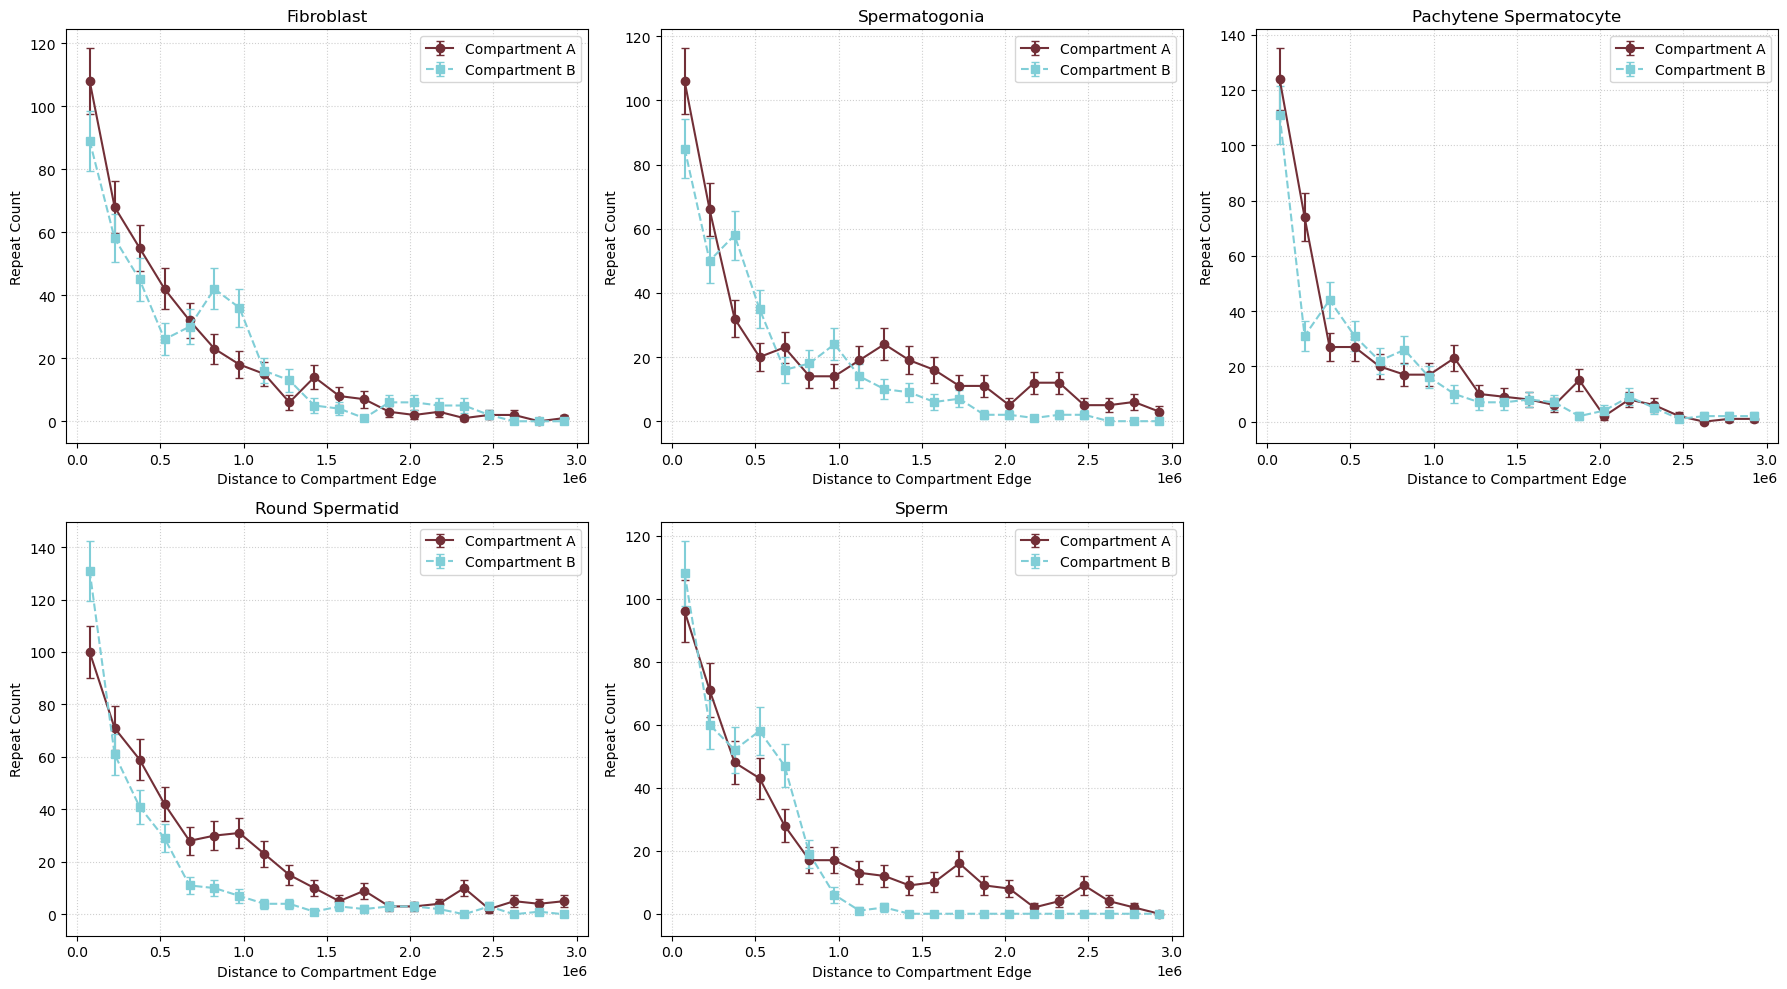

In [ ]:
import numpy as np
# import matplotlib.pyplot as plt

# A_color = "#722F37"  # Indigo
# B_color = "#80CED7"  # Coral

# # Desired order
# order = [
#     "fibroblast_e1_100kb_10Mb_edges",
#     "spermatogonia_e1_100kb_10Mb_edges",
#     "pachytene_spermatocyte_e1_100kb_10Mb_edges",
#     "round_spermatid_e1_100kb_10Mb_edges",
#     "sperm_e1_100kb_10Mb_edges",
# ]

# # Plot settings
# num_bins = 20
# max_dist = 3_000_000
# bins = np.linspace(0, max_dist, num_bins + 1)
# bin_centers = 0.5 * (bins[:-1] + bins[1:])

# def bin_absmid_with_error(absmid_values, bins):
#     counts, _ = np.histogram(absmid_values, bins=bins)
#     errors = np.sqrt(np.maximum(counts, 1))  # avoid 0 errorbars
#     return counts, errors

# # Prepare plot grid (2 rows x 3 cols)
# fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# axes = np.array(axes).flatten()

# plot_idx = 0
# for sample in order:
#     if sample not in remapped_simple_filter_data:
#         print(f"Warning: {sample} not found in remapped_simple_filter_data, skipping...")
#         continue
#     if plot_idx >= len(axes):
#         break

#     pair = remapped_simple_filter_data[sample]
#     A_df = pair["A"]
#     B_df = pair["B"]

#     counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna().values, bins)
#     counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna().values, bins)

#     ax = axes[plot_idx]
#     ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-', capsize=3,
#                 label='Compartment A', color=A_color)
#     ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--', capsize=3,
#                 label='Compartment B', color=B_color)

#     clean_title = sample.replace("_e1_100kb_10Mb_edges", "").replace("_", " ").title()
#     ax.set_title(clean_title)
#     ax.set_xlabel("Distance to Compartment Edge")
#     ax.set_ylabel("Repeat Count")
#     ax.grid(True, linestyle=":", alpha=0.6)
#     ax.legend()

#     plot_idx += 1

# # Hide unused axes
# for i in range(plot_idx, len(axes)):
#     axes[i].axis("off")

# plt.tight_layout()
# plt.savefig("/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/manuscript/illustrations/CPG_islands_chrx_not_normalized.png", dpi=300)
# plt.show()


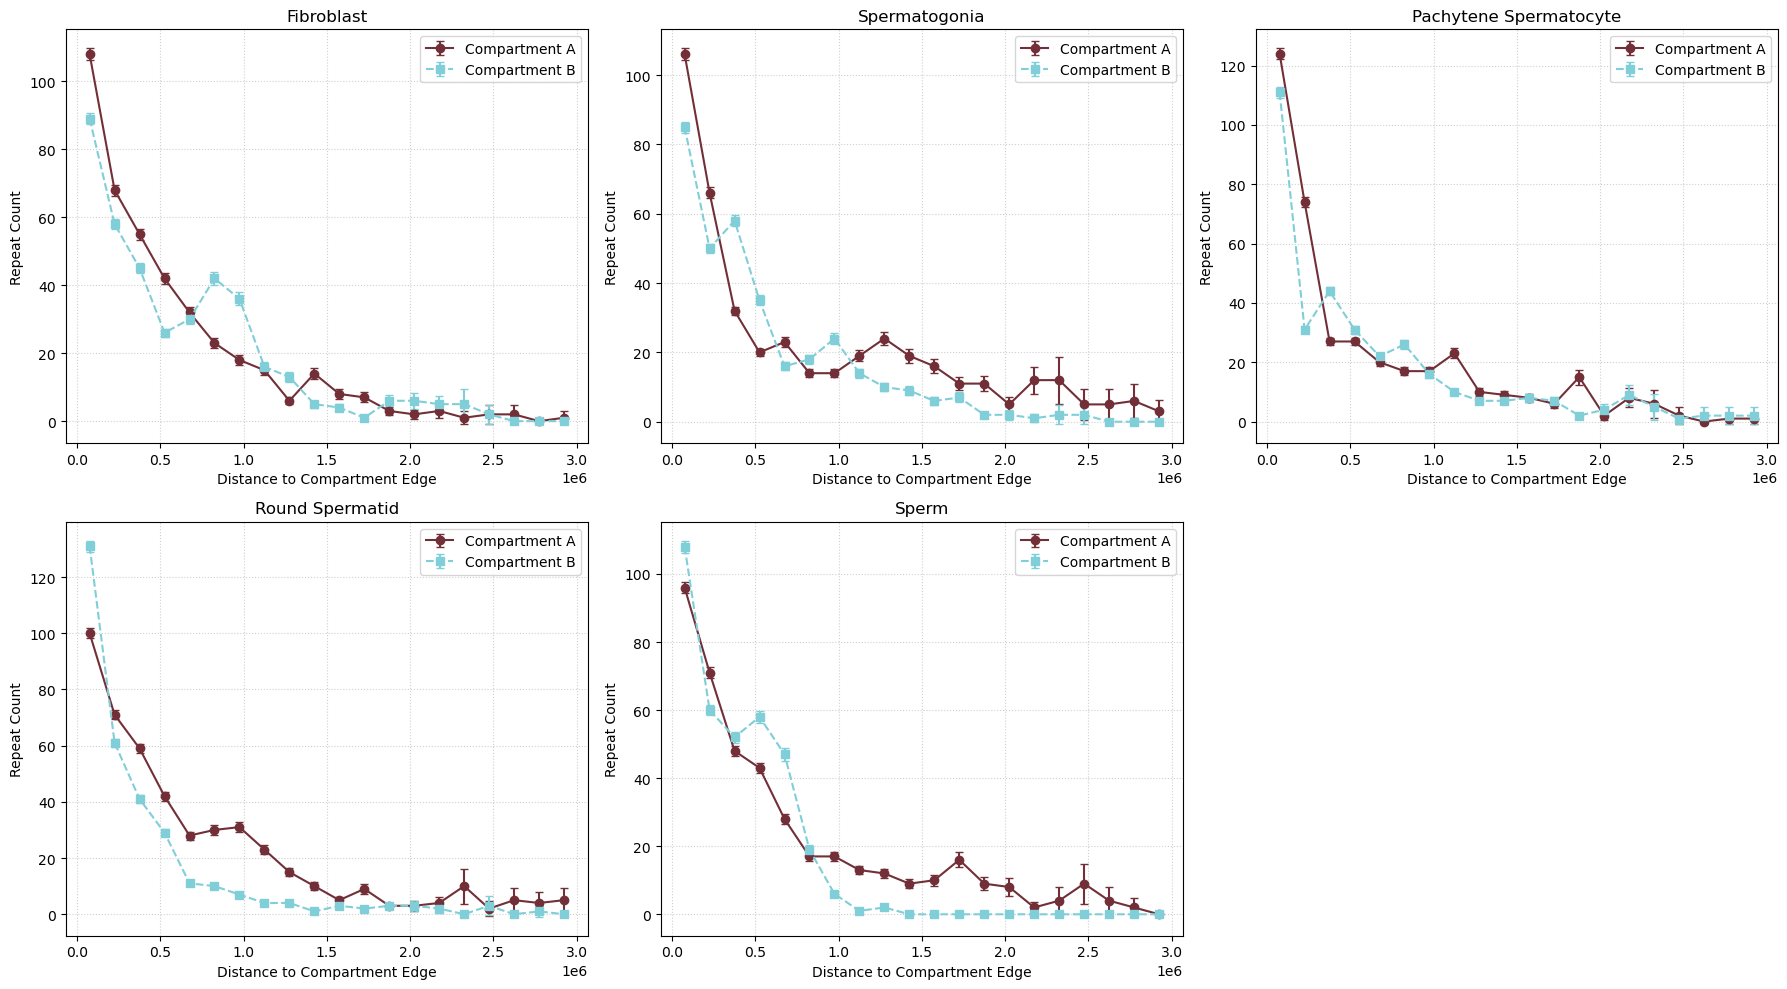

In [55]:

import numpy as np
import matplotlib.pyplot as plt

A_color = "#722F37"  # Indigo
B_color = "#80CED7"  # Coral

# Desired order
order = [
    "fibroblast_e1_100kb_10Mb_edges",
    "spermatogonia_e1_100kb_10Mb_edges",
    "pachytene_spermatocyte_e1_100kb_10Mb_edges",
    "round_spermatid_e1_100kb_10Mb_edges",
    "sperm_e1_100kb_10Mb_edges",
]

# Plot settings
num_bins = 20
max_dist = 3_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=num_bins):
    """
    Bin half-distances between consecutive 'start' positions,
    ignoring compartments (A/B) and returning a single result
    with both forward and reverse cumulative fractions.
    """
    bin_edges = np.linspace(0, max_dist, bins + 1)

    start = comp['start'].values
    if len(start) < 2:
        counts = np.zeros(bins, dtype=int)
    else:
        half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
        counts, _ = np.histogram(half_distances, bins=bin_edges)

    total = np.sum(counts)
    if total > 0:
        cumulative_fraction = np.cumsum(counts) / total
        reverse_cumulative_fraction = np.cumsum(counts[::-1])[::-1] / total
    else:
        cumulative_fraction = np.zeros(bins)
        reverse_cumulative_fraction = np.zeros(bins)

    reverse_cumulative = np.cumsum(counts[::-1])[::-1]

    result = {
        "counts": counts,
        "cumulative_fraction": cumulative_fraction,
        "reverse_cumulative_fraction": reverse_cumulative_fraction,
        "reverse_cumulative": reverse_cumulative
    }
    return result

def bin_absmid_with_error(absmid_values, bins, reverse_cumulative):
    """
    Calculate counts and symmetric error bars using
    SD = sqrt(count / n_possible), where n_possible = reverse_cumulative.
    """
    counts, _ = np.histogram(absmid_values, bins=bins)

    # Avoid divide-by-zero
    with np.errstate(divide='ignore', invalid='ignore'):
        errors = np.sqrt(counts / np.maximum(reverse_cumulative, 1))
        errors[np.isnan(errors)] = 0.0

    errors = 1.96 * errors  # 95% CI multiplier

    return counts, errors

# Prepare plot grid (2 rows x 3 cols)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = np.array(axes).flatten()
result = bin_half_distances_by_compartment(edge_df)

plot_idx = 0
for sample in order:
    if sample not in remapped_simple_filter_data:
        print(f"Warning: {sample} not found in remapped_simple_filter_data, skipping...")
        continue
    if plot_idx >= len(axes):
        break

    pair = remapped_simple_filter_data[sample]
    A_df = pair["A"]
    B_df = pair["B"]

    counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna().values, bins, result["reverse_cumulative"])
    counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna().values, bins, result["reverse_cumulative"])

    ax = axes[plot_idx]
    ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-', capsize=3,
                label='Compartment A', color=A_color)
    ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--', capsize=3,
                label='Compartment B', color=B_color)

    clean_title = sample.replace("_e1_100kb_10Mb_edges", "").replace("_", " ").title()
    ax.set_title(clean_title)
    ax.set_xlabel("Distance to Compartment Edge")
    ax.set_ylabel("Repeat Count")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()

    plot_idx += 1

# Hide unused axes
for i in range(plot_idx, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.savefig("/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/manuscript/illustrations/CPG_islands_chrx_not_normalized.png", dpi=300)
plt.show()

# AB or BA

In [11]:
def remapping_no_filter_compartment(df_repeats, df_compartment_anchors):
    """
    Remaps repeats to compartment edges and groups only by target compartment identity,
    ignoring directionality. Returns absolute distances for plotting.

    Parameters:
    - df_repeats: DataFrame with columns chrom, start, end
    - df_compartment_anchors: DataFrame with columns chrom, start, end, comp

    Returns:
    - A_val: DataFrame of repeats near compartment A
    - B_val: DataFrame of repeats near compartment B
    """
    # Clean and sort
    anchors = df_compartment_anchors.dropna(subset=["start", "end"]).copy()
    anchors["start"] = anchors["start"].astype(int)
    anchors["end"] = anchors["end"].astype(int)
    df_repeats = df_repeats.dropna(subset=["start", "end"]).copy()
    df_repeats["start"] = df_repeats["start"].astype(int)
    df_repeats["end"] = df_repeats["end"].astype(int)

    anchors = anchors.sort_values(by=['chrom', 'start', 'end'])
    df_repeats = df_repeats.sort_values(by=['chrom', 'start', 'end'])

    # Remap
    result = remap_interval_data(df_repeats, anchors, include_prox_coord=True)

    # Post-process
    result["mid"] = (result["start"] + result["end"]) / 2
    result["absmid"] = result["mid"].abs()
    result = result.dropna(subset=["start", "end", "mid", "absmid", "start_prox", "end_prox"], how="any")

    # Map compartment identity
    start_to_comp = anchors.drop_duplicates(subset=["start"]).set_index("start")["comp"]
    result["comp"] = result["start_prox"].map(start_to_comp)

    # Split only based on target compartment (ignore direction)
    A_val = result[result['comp'] == 'A'].copy()
    B_val = result[result['comp'] == 'B'].copy()

    A_val["abs_start"] = A_val["start"].abs()
    B_val["abs_start"] = B_val["start"].abs()
    A_val["group"] = "Compartment A"
    B_val["group"] = "Compartment B"

    return A_val, B_val

In [12]:
ab_dfs = {name: obj for name, obj in globals().items()
          if name.endswith('_AB') and isinstance(obj, pd.DataFrame)}
remapped_data = {}

for name, df_anchor in ab_dfs.items():
    print(f"\nRunning on: {name}")
    try:
        A_value, B_value = remapping_no_filter_compartment(df_chrX, df_anchor)
        remapped_data[name.replace('_AB', '')] = {"A": A_value, "B": B_value}
        print(f"  A_value: {A_value.shape}, B_value: {B_value.shape}")
    except Exception as e:
        print(f"  ❌ Failed on {name}: {e}")


Running on: sperm_e1_100kb_10Mb_edges_AB
  A_value: (309, 12), B_value: (471, 12)

Running on: round_spermatid_e1_100kb_10Mb_edges_AB
  A_value: (333, 12), B_value: (443, 12)

Running on: pachytene_spermatocyte_e1_100kb_10Mb_edges_AB
  A_value: (331, 12), B_value: (423, 12)

Running on: spermatogonia_e1_100kb_10Mb_edges_AB
  A_value: (285, 12), B_value: (488, 12)

Running on: fibroblast_e1_100kb_10Mb_edges_AB
  A_value: (392, 12), B_value: (407, 12)


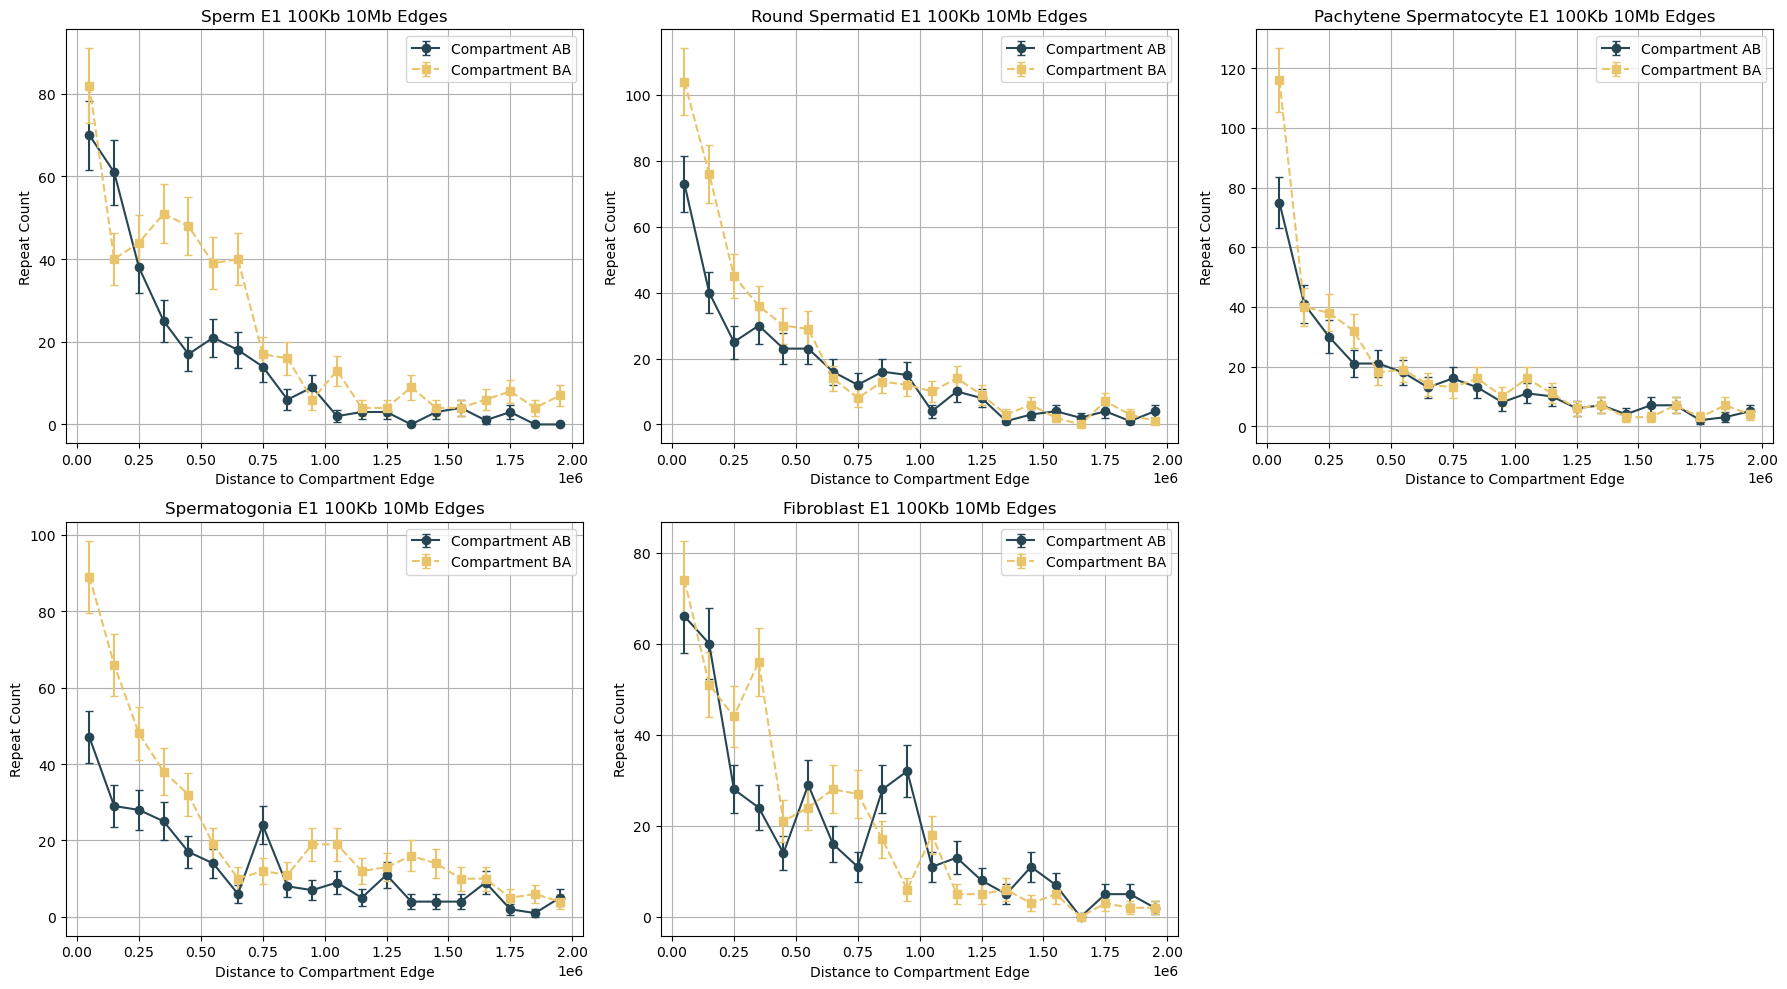

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# # pick one pair
# A_color = "#264653"  # Indigo
# B_color = "#E9C46A"  # Coral

# # Plot settings
# num_bins = 20
# max_dist = 2_000_000
# bins = np.linspace(0, max_dist, num_bins + 1)
# bin_centers = 0.5 * (bins[:-1] + bins[1:])

# def bin_absmid_with_error(absmid_values, bins):
#     counts, _ = np.histogram(absmid_values, bins=bins)
#     errors = np.sqrt(counts)
#     return counts, errors

# # Prepare plot grid
# fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# axes = axes.flatten()

# # Loop through samples
# for idx, (sample, pair) in enumerate(remapped_data.items()):
#     A_df = pair["A"]
#     B_df = pair["B"]

#     # Bin 'absmid'
#     counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna(), bins)
#     counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna(), bins)

#     ax = axes[idx]
#     ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-', capsize=3, label='Compartment AB',color=A_color)
#     ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--', capsize=3, label='Compartment BA',color=B_color)
#     ax.set_title(sample.replace("_", " ").title())
#     ax.set_xlabel("Distance to Compartment Edge")
#     ax.set_ylabel("Repeat Count")
#     ax.grid(True)
#     ax.legend()

# # Hide unused subplot (slot 6)
# if len(remapped_data) < len(axes):
#     for i in range(len(remapped_data), len(axes)):
#         axes[i].axis('off')

# plt.tight_layout()
# plt.show()

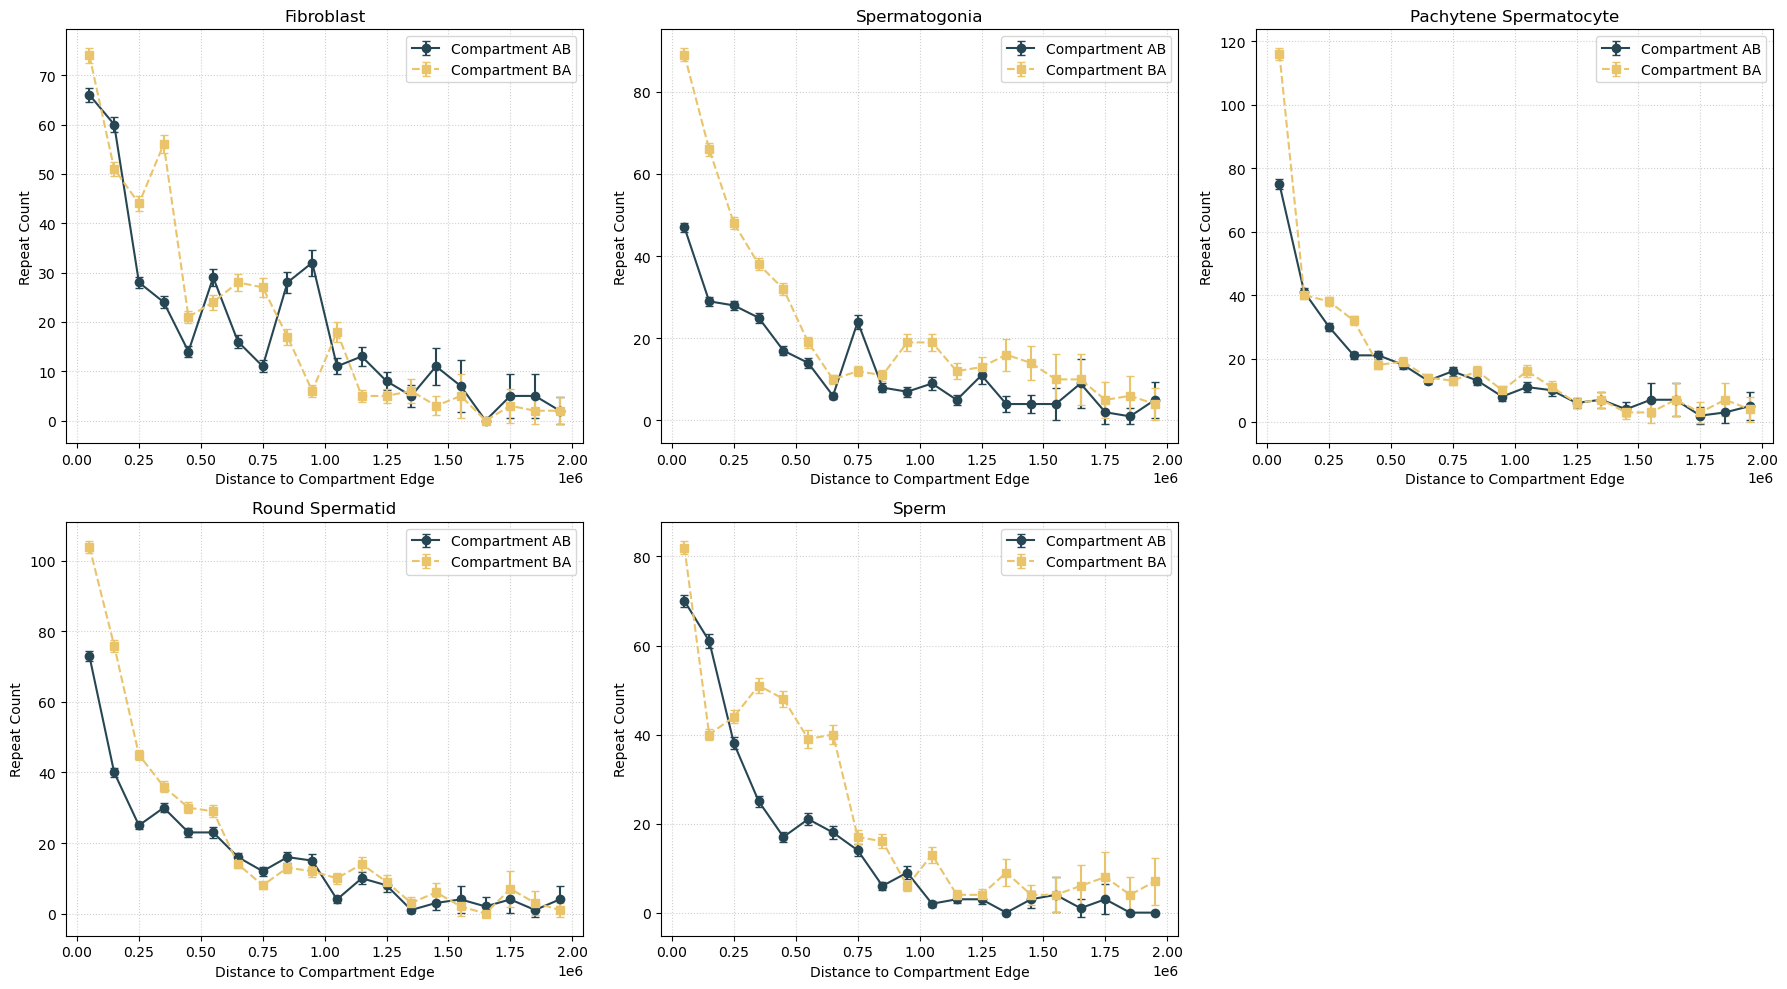

In [53]:
import numpy as np
import matplotlib.pyplot as plt

A_color = "#264653"  # Indigo
B_color = "#E9C46A"  # Coral

# Desired order (keys in remapped_data)
order = [
    "fibroblast_e1_100kb_10Mb_edges",
    "spermatogonia_e1_100kb_10Mb_edges",
    "pachytene_spermatocyte_e1_100kb_10Mb_edges",
    "round_spermatid_e1_100kb_10Mb_edges",
    "sperm_e1_100kb_10Mb_edges",
]

# Plot settings
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])


def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=num_bins):
    """
    Bin half-distances between consecutive 'start' positions,
    ignoring compartments (A/B) and returning a single result
    with both forward and reverse cumulative fractions.
    """
    bin_edges = np.linspace(0, max_dist, bins + 1)

    start = comp['start'].values
    if len(start) < 2:
        counts = np.zeros(bins, dtype=int)
    else:
        half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
        counts, _ = np.histogram(half_distances, bins=bin_edges)

    total = np.sum(counts)
    if total > 0:
        cumulative_fraction = np.cumsum(counts) / total
        reverse_cumulative_fraction = np.cumsum(counts[::-1])[::-1] / total
    else:
        cumulative_fraction = np.zeros(bins)
        reverse_cumulative_fraction = np.zeros(bins)

    reverse_cumulative = np.cumsum(counts[::-1])[::-1]

    result = {
        "counts": counts,
        "cumulative_fraction": cumulative_fraction,
        "reverse_cumulative_fraction": reverse_cumulative_fraction,
        "reverse_cumulative": reverse_cumulative
    }
    return result

def bin_absmid_with_error(absmid_values, bins, reverse_cumulative):
    """
    Calculate counts and symmetric error bars using
    SD = sqrt(count / n_possible), where n_possible = reverse_cumulative.
    """
    counts, _ = np.histogram(absmid_values, bins=bins)

    # Avoid divide-by-zero
    with np.errstate(divide='ignore', invalid='ignore'):
        errors = np.sqrt(counts / np.maximum(reverse_cumulative, 1))
        errors[np.isnan(errors)] = 0.0

    errors = 1.96 * errors  # 95% CI multiplier

    return counts, errors

# Layout (2x3 fits up to 6)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = np.array(axes).flatten()
result = bin_half_distances_by_compartment(edge_df)

# Only keep samples that exist
present = [s for s in order if s in remapped_data]

plot_idx = 0
for sample in present:
    if plot_idx >= len(axes):
        break  # safety

    pair = remapped_data[sample]
    A_df = pair["A"]
    B_df = pair["B"]

    counts_A, errors_A = bin_absmid_with_error(A_df['absmid'].dropna().values, bins, result["reverse_cumulative"])
    counts_B, errors_B = bin_absmid_with_error(B_df['absmid'].dropna().values, bins, result["reverse_cumulative"])

    ax = axes[plot_idx]
    ax.errorbar(bin_centers, counts_A, yerr=errors_A, marker='o', linestyle='-',
                capsize=3, label='Compartment AB', color=A_color)
    ax.errorbar(bin_centers, counts_B, yerr=errors_B, marker='s', linestyle='--',
                capsize=3, label='Compartment BA', color=B_color)

    clean_title = sample.replace("_e1_100kb_10Mb_edges", "").replace("_", " ").title()
    ax.set_title(clean_title)
    ax.set_xlabel("Distance to Compartment Edge")
    ax.set_ylabel("Repeat Count")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()

    plot_idx += 1

# Hide unused subplots
for i in range(plot_idx, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()



## corected for lenght between edges

In [14]:
import numpy as np

def bin_half_distances(comp, max_dist=2_000_000, bins=20):
    start = comp['start'].values
    # Compute half-distances between consecutive start positions
    half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]

    # Bin those distances
    bin_edges = np.linspace(0, max_dist, bins + 1)
    counts, _ = np.histogram(half_distances, bins=bin_edges)

    # Reverse cumulative sum — how many possible contributing edges for each bin
    reverse_cumulative_counts = np.cumsum(counts[::-1])[::-1]

    return counts, reverse_cumulative_counts

In [15]:
# import numpy as np
# import matplotlib.pyplot as plt

# # --- Parameters ---
# max_dist = 2_000_000
# num_bins = 20
# bin_edges = np.linspace(0, max_dist, num_bins + 1)
# bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# # --- Function to bin half-distances by compartment ---
# def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=20):
#     bin_edges = np.linspace(0, max_dist, bins + 1)
#     results = {}

#     for compartment in ['A', 'B']:
#         subset = comp[comp['comp'] == compartment]
#         start = subset['start'].values

#         if len(start) < 2:
#             counts = np.zeros(bins, dtype=int)
#         else:
#             # Compute half-distances
#             half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
#             counts, _ = np.histogram(half_distances, bins=bin_edges)

#         results[compartment] = {
#             "counts": counts,
#             "cumulative_fraction": np.cumsum(counts) / np.sum(counts) if np.sum(counts) > 0 else np.zeros(bins)
#         }

#     return results

# # --- Run the function ---
# # Replace this with your actual DataFrame
# # Example: edge_df = sperm_e1_100kb_10Mb_edges_AB
# edge_df = sperm_e1_100kb_10Mb_edges_AB  # Example

# # Get results for A and B
# dist_data = bin_half_distances_by_compartment(edge_df)
# print("Compartment A (first 10 cumulative fractions):", dist_data["A"]["cumulative_fraction"][:10])
# print("Compartment B (first 10 cumulative fractions):", dist_data["B"]["cumulative_fraction"][:10])


# # --- Plot ---
# plt.figure(figsize=(8, 5))
# plt.plot(bin_centers, dist_data["A"]["cumulative_fraction"], marker='o', label='Compartment A')
# plt.plot(bin_centers, dist_data["B"]["cumulative_fraction"], marker='s', label='Compartment B')

# plt.title("Forward Cumulative Edge Distances by Compartment")
# plt.xlabel("Half-Distance from Compartment Edge (bp)")
# plt.ylabel("Cumulative Fraction of Edges")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


Compartment A (first 10 cumulative fractions): [0.         0.17241379 0.22413793 0.29310345 0.44827586 0.48275862
 0.55172414 0.60344828 0.65517241 0.72413793]
Compartment B (first 10 cumulative fractions): [0.         0.11864407 0.16949153 0.28813559 0.38983051 0.49152542
 0.52542373 0.54237288 0.61016949 0.6440678 ]


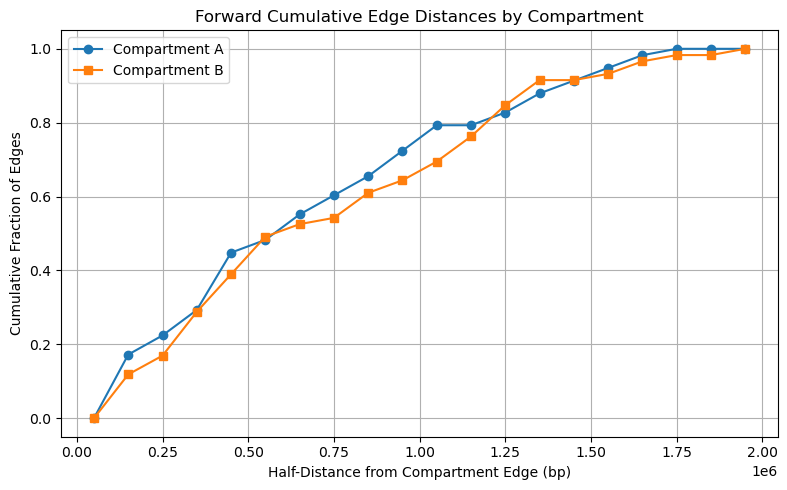

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
max_dist = 2_000_000
num_bins = 20
bin_edges = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# --- Function to bin half-distances by compartment ---

def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=20):
    bin_edges = np.linspace(0, max_dist, bins + 1)

    results_A = {}
    results_B = {}

    for compartment, result in zip(['A', 'B'], [results_A, results_B]):
        subset = comp[comp['comp'] == compartment]
        start = subset['start'].values

        if len(start) < 2:
            counts = np.zeros(bins, dtype=int)
        else:
            half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
            counts, _ = np.histogram(half_distances, bins=bin_edges)

        result["counts"] = counts
        result["cumulative_fraction"] = (
            np.cumsum(counts) / np.sum(counts) if np.sum(counts) > 0 else np.zeros(bins)
        )

    return results_A, results_B

# --- Run the function ---
# Replace this with your actual DataFrame
# Example: edge_df = sperm_e1_100kb_10Mb_edges_AB
edge_df = sperm_e1_100kb_10Mb_edges_AB  # Example

# Get results for A and B
result_A, result_B = bin_half_distances_by_compartment(edge_df)

print("Compartment A (first 10 cumulative fractions):", result_A["cumulative_fraction"][:10])
print("Compartment B (first 10 cumulative fractions):", result_B["cumulative_fraction"][:10])

# Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, result_A["cumulative_fraction"], marker='o', label='Compartment A')
plt.plot(bin_centers, result_B["cumulative_fraction"], marker='s', label='Compartment B')


plt.title("Forward Cumulative Edge Distances by Compartment")
plt.xlabel("Half-Distance from Compartment Edge (bp)")
plt.ylabel("Cumulative Fraction of Edges")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
ab_dfs = {name: obj for name, obj in globals().items()
          if name.endswith('_AB') and isinstance(obj, pd.DataFrame)}
remapped_simple_filter_data = {}

for name, df_anchor in ab_dfs.items():
    print(f"\nRunning on: {name}")
    try:
        A_value, B_value = plot_repeat_density_vs_compartment_edge(df_chrX, df_anchor)
        remapped_simple_filter_data[name.replace('_AB', '')] = {"A": A_value, "B": B_value}
        print(f"  A_value: {A_value.shape}, B_value: {B_value.shape}")
    except Exception as e:
        print(f"  ❌ Failed on {name}: {e}")


Running on: sperm_e1_100kb_10Mb_edges_AB
  A_value: (427, 12), B_value: (353, 12)

Running on: round_spermatid_e1_100kb_10Mb_edges_AB
  A_value: (459, 12), B_value: (317, 12)

Running on: pachytene_spermatocyte_e1_100kb_10Mb_edges_AB
  A_value: (398, 12), B_value: (356, 12)

Running on: spermatogonia_e1_100kb_10Mb_edges_AB
  A_value: (432, 12), B_value: (341, 12)

Running on: fibroblast_e1_100kb_10Mb_edges_AB
  A_value: (410, 12), B_value: (389, 12)


In [18]:
ab_dfs = {name: obj for name, obj in globals().items()
          if name.endswith('_AB') and isinstance(obj, pd.DataFrame)}
remapped_data = {}

for name, df_anchor in ab_dfs.items():
    print(f"\nRunning on: {name}")
    try:
        A_value, B_value = remapping_no_filter_compartment(df_chrX, df_anchor)
        remapped_data[name.replace('_AB', '')] = {"A": A_value, "B": B_value}
        print(f"  A_value: {A_value.shape}, B_value: {B_value.shape}")
    except Exception as e:
        print(f"  ❌ Failed on {name}: {e}")


Running on: sperm_e1_100kb_10Mb_edges_AB
  A_value: (309, 12), B_value: (471, 12)

Running on: round_spermatid_e1_100kb_10Mb_edges_AB
  A_value: (333, 12), B_value: (443, 12)

Running on: pachytene_spermatocyte_e1_100kb_10Mb_edges_AB
  A_value: (331, 12), B_value: (423, 12)

Running on: spermatogonia_e1_100kb_10Mb_edges_AB
  A_value: (285, 12), B_value: (488, 12)

Running on: fibroblast_e1_100kb_10Mb_edges_AB
  A_value: (392, 12), B_value: (407, 12)


## hej


To model a Poisson distribution \( P(r, L) \), where \( r \) is the observed count (e.g., number of CpG islands in a bin) and \( L \) is the expected mean (e.g., average count per bin), use:
Yes, you can use those values for `r` and `L` in the Poisson formula. Here is the code that fits at the placeholder:

To compute the Poisson probability for your example:

\[
P(r, L) = \text{poisson.pmf}(r, L)
\]

where  
- \( r = 95 \times 100000 \times 120 \)  
- \( L = 100000 \times 120 \)

```python
r = 95 * 100000 * 120
L = 100000 * 120
P = poisson.pmf(r, L)
P
```

This will give you the probability of observing exactly `r` events when the expected mean is `L`. For large values, the probability will be extremely small due to the nature of the Poisson distribution.
- For fitting, you can estimate `L` as the mean count per bin: `L = np.mean(counts_A)` (or any other group).

You can also plot the Poisson distribution for a range of `r`:

```python
import numpy as np
import matplotlib.pyplot as plt

L = np.mean(counts_A)  # example mean
r_values = np.arange(0, np.max(counts_A)+1)
P_values = poisson.pmf(r_values, L)

plt.bar(r_values, P_values)
plt.xlabel('Observed count (r)')
plt.ylabel('Poisson Probability P(r, L)')
plt.title(f'Poisson Distribution (λ={L:.2f})')
plt.show()
```

Replace `counts_A` with your actual data.

[66 60 28 24 14]
Estimated mean (L): 18.75


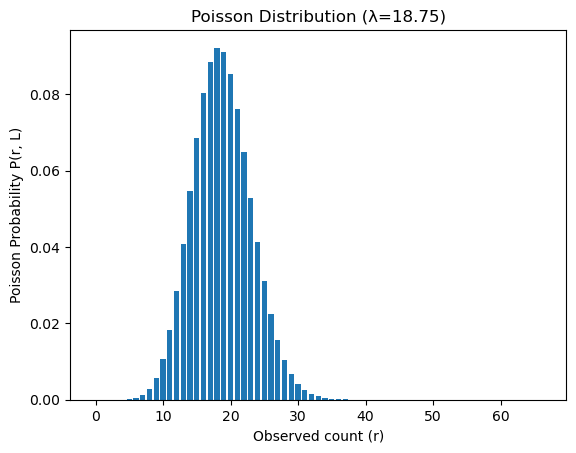

Probability of observing r=66 when λ=18.75: 1.38e-17


In [19]:
from scipy.stats import poisson
import numpy as np

import matplotlib.pyplot as plt
print(counts_A[:5])

# Estimate expected mean (L) from your observed bin counts
L = np.mean(counts_A)
print(f"Estimated mean (L): {L:.2f}")

# Compute Poisson probability for each observed count in counts_A
r_values = np.arange(0, np.max(counts_A) + 1)
P_values = poisson.pmf(r_values, L)

# Plot Poisson distribution for the observed range
plt.bar(r_values, P_values)
plt.xlabel('Observed count (r)')
plt.ylabel('Poisson Probability P(r, L)')
plt.title(f'Poisson Distribution (λ={L:.2f})')
plt.show()

# Example: probability of observing the maximum count in counts_A
r_max = np.max(counts_A)
P_max = poisson.pmf(r_max, L)
print(f"Probability of observing r={r_max} when λ={L:.2f}: {P_max:.2e}")

Compartment A (first 10 cumulative fractions): [0.         0.17241379 0.22413793 0.29310345 0.44827586 0.48275862
 0.55172414 0.60344828 0.65517241 0.72413793]
Compartment B (first 10 cumulative fractions): [0.         0.11864407 0.16949153 0.28813559 0.38983051 0.49152542
 0.52542373 0.54237288 0.61016949 0.6440678 ]
Compartment A (first 10 count): [ 0 10  3  4  9  2  4  3  3  4  4  0  2  3  2  2  2  1  0  0]
Compartment B (first 10 count): [0 7 3 7 6 6 2 1 4 2 3 4 5 4 0 1 2 1 0 1]
Compartment A (first 10 cumulative count): [ 0 10 13 17 26 28 32 35 38 42]


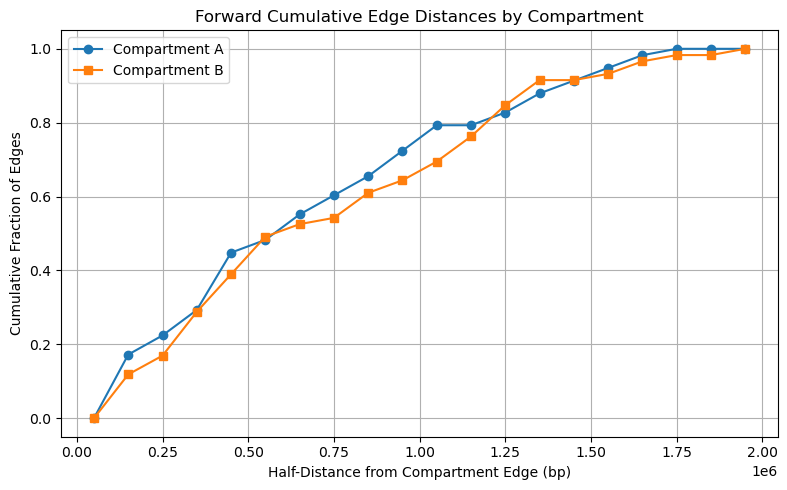

In [20]:
import numpy as np
import matplotlib.pyplot as plt



# --- Parameters ---
max_dist = 2_000_000
num_bins = 20
bin_edges = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# --- Function to bin half-distances by compartment ---

def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=20):
    bin_edges = np.linspace(0, max_dist, bins + 1)

    results_A = {}
    results_B = {}

    for compartment, result in zip(['A', 'B'], [results_A, results_B]):
        subset = comp[comp['comp'] == compartment]
        start = subset['start'].values

        if len(start) < 2:
            counts = np.zeros(bins, dtype=int)
        else:
            half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
            counts, _ = np.histogram(half_distances, bins=bin_edges)

        result["counts"] = counts
        cumulative_count = np.cumsum(counts)
        result["cumulative_count"] = cumulative_count
        result["cumulative_fraction"] = (
            np.cumsum(counts) / np.sum(counts) if np.sum(counts) > 0 else np.zeros(bins)
        )

    return results_A, results_B #, A_uncorected, B_uncorrected

# --- Run the function ---
# Replace this with your actual DataFrame
# Example: edge_df = sperm_e1_100kb_10Mb_edges_AB
edge_df = sperm_e1_100kb_10Mb_edges_AB  # Example

# Get results for A and B
result_A, result_B = bin_half_distances_by_compartment(edge_df)

print("Compartment A (first 10 cumulative fractions):", result_A["cumulative_fraction"][:10])
print("Compartment B (first 10 cumulative fractions):", result_B["cumulative_fraction"][:10])
print("Compartment A (first 10 count):", result_A["counts"])
print("Compartment B (first 10 count):", result_B["counts"])
print("Compartment A (first 10 cumulative count):", result_A["cumulative_count"][:10])


# Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, result_A["cumulative_fraction"], marker='o', label='Compartment A')
plt.plot(bin_centers, result_B["cumulative_fraction"], marker='s', label='Compartment B')


plt.title("Forward Cumulative Edge Distances by Compartment")
plt.xlabel("Half-Distance from Compartment Edge (bp)")
plt.ylabel("Cumulative Fraction of Edges")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

missing code

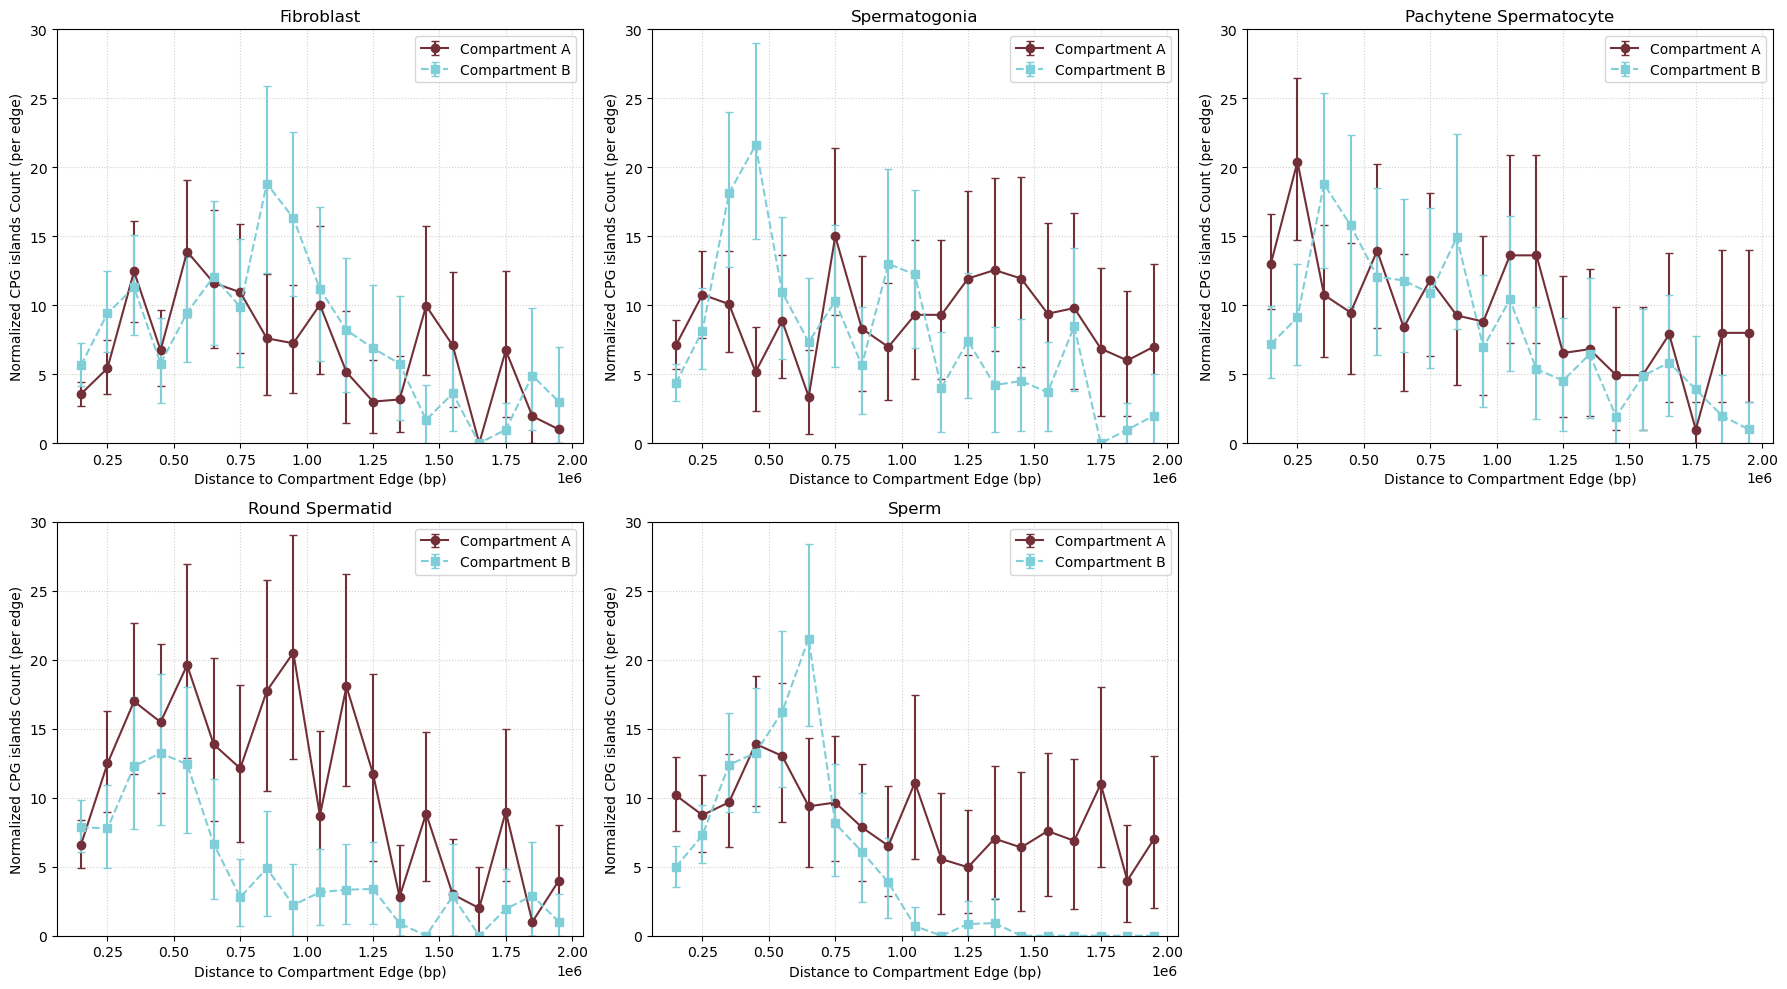

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

A_color = "#722F37"  # Indigo
B_color = "#80CED7"  # Coral

# Desired order
order = [
    "fibroblast_e1_100kb_10Mb_edges",
    "spermatogonia_e1_100kb_10Mb_edges",
    "pachytene_spermatocyte_e1_100kb_10Mb_edges",
    "round_spermatid_e1_100kb_10Mb_edges",
    "sperm_e1_100kb_10Mb_edges",
]

# Plot settings
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Updated error calculation
def bin_absmid_with_poisson_CI(absmid_values, bins, cumulative_fraction, max_dist):
    counts, _ = np.histogram(absmid_values, bins=bins)
    expected = np.where(counts <= 0, 1e-10, counts)  # avoid zeros
    lower, upper = stats.poisson.interval(0.95, expected)
    lower_error = np.maximum(expected - lower, 0)
    upper_error = np.maximum(upper - expected, 0)
    return counts, np.vstack([lower_error, upper_error])

# Prepare grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = np.array(axes).flatten()

plot_idx = 0
for sample in order:
    if sample not in remapped_simple_filter_data:
        print(f"⚠️ Warning: {sample} not found, skipping…")
        continue

    edge_key = f"{sample}_AB"
    if edge_key not in globals():
        print(f"⚠️ Warning: {edge_key} not found, skipping…")
        continue

    pair = remapped_simple_filter_data[sample]
    A_df = pair["A"]
    B_df = pair["B"]

    edge_df = globals()[edge_key]
    result_A, result_B = bin_half_distances_by_compartment(edge_df)

    counts_A, raw_errors_A = bin_absmid_with_poisson_CI(
        A_df['absmid'].dropna().values, bins, result_A["cumulative_fraction"], max_dist
    )
    counts_B, raw_errors_B = bin_absmid_with_poisson_CI(
        B_df['absmid'].dropna().values, bins, result_B["cumulative_fraction"], max_dist
    )

    # Normalize counts
    norm_cumulative_A = np.where(result_A["cumulative_fraction"] == 0, np.nan, result_A["cumulative_fraction"])
    norm_cumulative_B = np.where(result_B["cumulative_fraction"] == 0, np.nan, result_B["cumulative_fraction"])

    norm_counts_A = counts_A * norm_cumulative_A
    norm_counts_B = counts_B * norm_cumulative_B
    norm_errors_A = raw_errors_A * norm_cumulative_A
    norm_errors_B = raw_errors_B * norm_cumulative_B

    # Plot
    ax = axes[plot_idx]
    ax.errorbar(bin_centers, norm_counts_A, yerr=norm_errors_A, marker='o',
                linestyle='-', capsize=3, label='Compartment A', color=A_color)
    ax.errorbar(bin_centers, norm_counts_B, yerr=norm_errors_B, marker='s',
                linestyle='--', capsize=3, label='Compartment B', color=B_color)

    clean_title = sample.replace("_e1_100kb_10Mb_edges", "").replace("_", " ").title()
    ax.set_title(clean_title)
    ax.set_xlabel("Distance to Compartment Edge (bp)")
    ax.set_ylabel("Normalized CPG islands Count (per edge)")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()
    ax.set_ylim(0, 30)

    plot_idx += 1

# Hide unused panels
for i in range(plot_idx, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.savefig(
    "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/manuscript/illustrations/CPG_islands_chrx_normalized_poisson_CI.png",
    dpi=300
)
plt.show()


[0.20833333 0.4        0.54166667 0.59166667 0.66666667 0.69166667
 0.73333333 0.75833333 0.79166667 0.85833333 0.85833333 0.86666667
 0.9        0.91666667 0.93333333 0.975      0.98333333 0.98333333
 0.99166667 1.        ]
[25 23 17  6  9  3  5  3  4  8  0  1  4  2  2  5  1  0  1  1]
[120  95  72  55  49  40  37  32  29  25  17  17  16  12  10   8   3   2
   2   1]

Sample: fibroblast_e1_100kb_10Mb_edges
Counts A: [81 63 32 44 21 32 22 20 13 12 14  7  4  4 12  8  0  7  2  1]
Counts B: [59 48 40 36 14 21 22 18 32 26 15 11  9  7  2  4  0  1  5  3]

Sample: fibroblast_e1_100kb_10Mb_edges
Bin 1: 0–100000 bp | Count A = 81, Count B = 59, n_possible = 120
Bin 2: 100000–200000 bp | Count A = 63, Count B = 48, n_possible = 95
Bin 3: 200000–300000 bp | Count A = 32, Count B = 40, n_possible = 72
Bin 4: 300000–400000 bp | Count A = 44, Count B = 36, n_possible = 55
Bin 5: 400000–500000 bp | Count A = 21, Count B = 14, n_possible = 49
Bin 6: 500000–600000 bp | Count A = 32, Count B = 21, n_poss

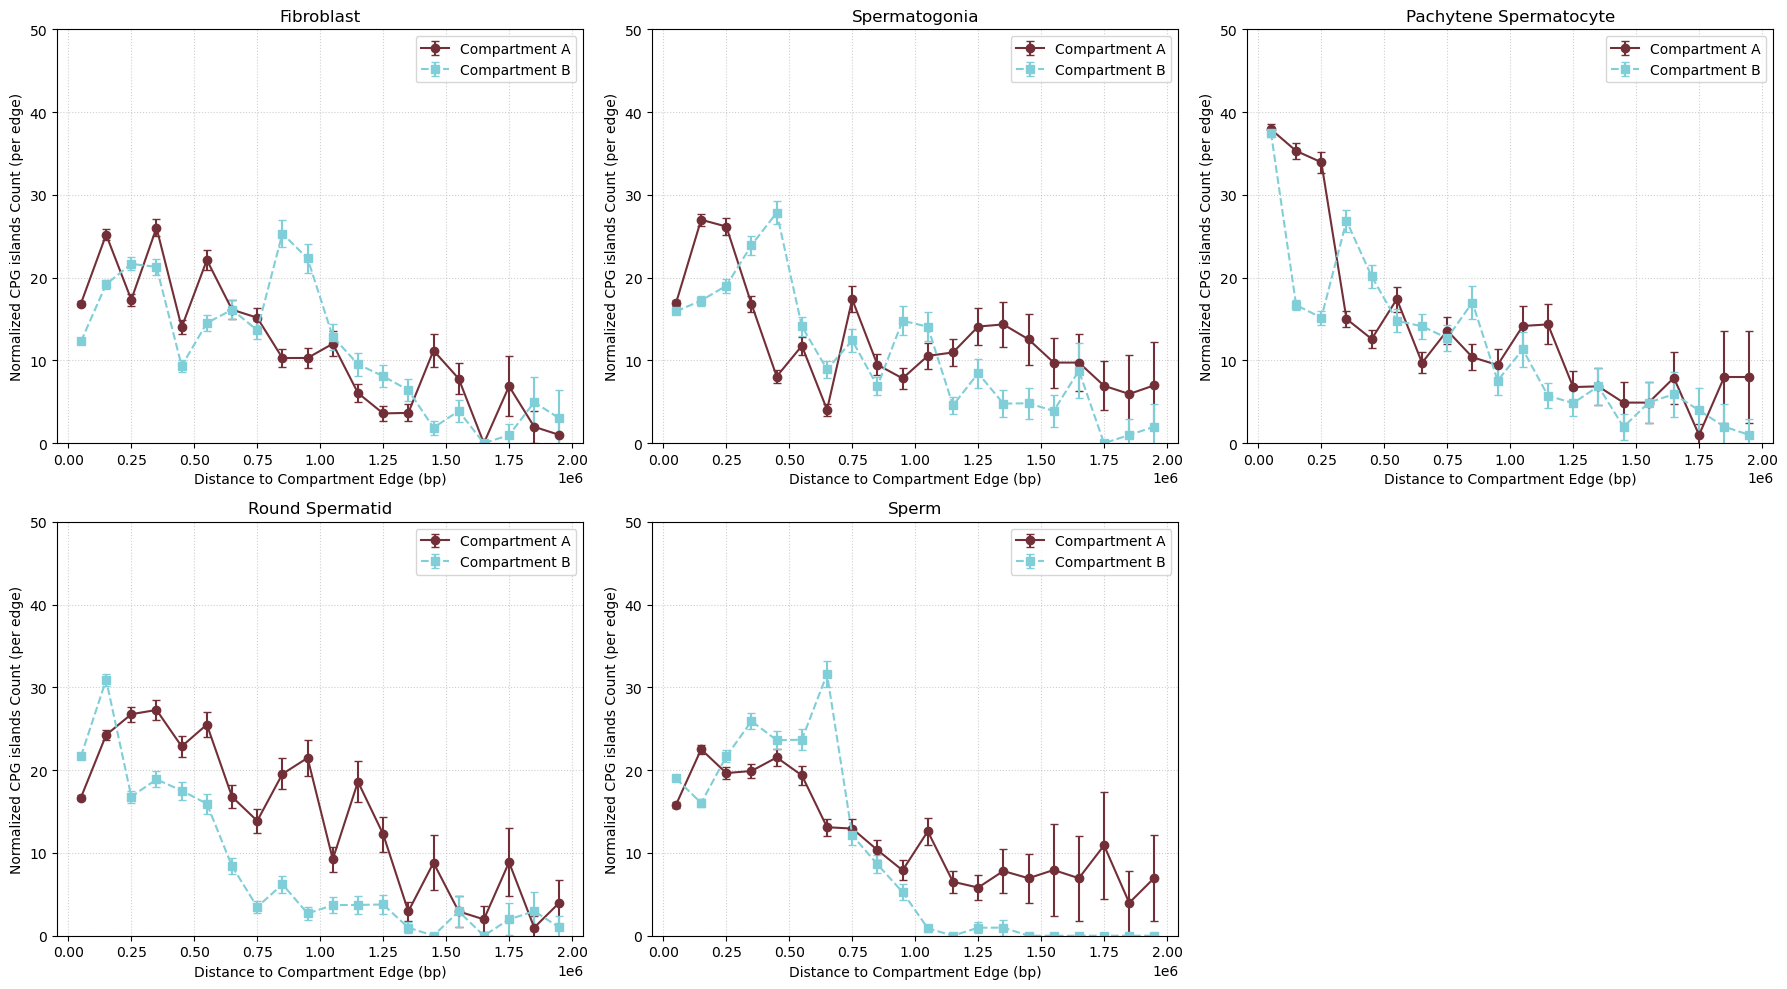

In [50]:

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

A_color = "#722F37"  # Indigo
B_color = "#80CED7"  # Coral

# Desired order
order = [
    "fibroblast_e1_100kb_10Mb_edges",
    "spermatogonia_e1_100kb_10Mb_edges",
    "pachytene_spermatocyte_e1_100kb_10Mb_edges",
    "round_spermatid_e1_100kb_10Mb_edges",
    "sperm_e1_100kb_10Mb_edges",
]

# Plot settings
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=num_bins):
    """
    Bin half-distances between consecutive 'start' positions,
    ignoring compartments (A/B) and returning a single result
    with both forward and reverse cumulative fractions.
    """
    bin_edges = np.linspace(0, max_dist, bins + 1)

    start = comp['start'].values
    if len(start) < 2:
        counts = np.zeros(bins, dtype=int)
    else:
        half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
        counts, _ = np.histogram(half_distances, bins=bin_edges)

    total = np.sum(counts)
    if total > 0:
        cumulative_fraction = np.cumsum(counts) / total
        reverse_cumulative_fraction = np.cumsum(counts[::-1])[::-1] / total
    else:
        cumulative_fraction = np.zeros(bins)
        reverse_cumulative_fraction = np.zeros(bins)

    reverse_cumulative = np.cumsum(counts[::-1])[::-1]

    result = {
        "counts": counts,
        "cumulative_fraction": cumulative_fraction,
        "reverse_cumulative_fraction": reverse_cumulative_fraction,
        "reverse_cumulative": reverse_cumulative
    }
    return result

# ONLY CHANGE: Updated error calculation to account for variable sample sizes
def bin_absmid_with_sd(absmid_values, bins, reverse_cumulative):
    """
    Calculate counts and symmetric error bars using
    SD = sqrt(count / n_possible), where n_possible = reverse_cumulative.
    """
    counts, _ = np.histogram(absmid_values, bins=bins)

    # Avoid divide-by-zero
    with np.errstate(divide='ignore', invalid='ignore'):
        errors = np.sqrt(counts / np.maximum(reverse_cumulative, 1))
        errors[np.isnan(errors)] = 0.0

    errors = 1.96 * errors  # 95% CI multiplier

    return counts, errors


# Prepare grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = np.array(axes).flatten()

plot_idx = 0
for sample in order:
    if sample not in remapped_simple_filter_data:
        print(f"⚠️ Warning: {sample} not found, skipping…")
        continue

    edge_key = f"{sample}_AB"
    if edge_key not in globals():
        print(f"⚠️ Warning: {edge_key} not found, skipping…")
        continue

    pair = remapped_simple_filter_data[sample]
    A_df = pair["A"]
    B_df = pair["B"]

    edge_df = globals()[edge_key]
    result = bin_half_distances_by_compartment(edge_df)

    
    # Use SD-based errors
    counts_A, errors_A = bin_absmid_with_sd(
        A_df['absmid'].dropna().values, bins, result["reverse_cumulative"]
    )
    counts_B, errors_B = bin_absmid_with_sd(
        B_df['absmid'].dropna().values, bins, result["reverse_cumulative"]
    )

    
    print(result["cumulative_fraction"])
    print(result["counts"])
    print(result["reverse_cumulative"])
        # 🔎 Print raw counts per bin (before normalization)
    print(f"\nSample: {sample}")
    print("Counts A:", counts_A)
    print("Counts B:", counts_B)
    print(f"\nSample: {sample}")
    for i in range(len(bins) - 1):
        print(f"Bin {i+1}: {bins[i]:.0f}–{bins[i+1]:.0f} bp | "
              f"Count A = {counts_A[i]}, Count B = {counts_B[i]}, "
              f"n_possible = {result['reverse_cumulative'][i]}")

    # Normalize counts (same as before)
    norm_cumulative_A = np.where(result["cumulative_fraction"] == 0, np.nan, result["cumulative_fraction"])
    norm_cumulative_B = np.where(result["cumulative_fraction"] == 0, np.nan, result["cumulative_fraction"])

    norm_counts_A = counts_A * norm_cumulative_A
    norm_counts_B = counts_B * norm_cumulative_B
    norm_errors_A = errors_A * norm_cumulative_A
    norm_errors_B = errors_B * norm_cumulative_B

    # Plot (EXACTLY THE SAME AS BEFORE)
    ax = axes[plot_idx]
    ax.errorbar(bin_centers, norm_counts_A, yerr=norm_errors_A, marker='o',
                linestyle='-', capsize=3, label='Compartment A', color=A_color)
    ax.errorbar(bin_centers, norm_counts_B, yerr=norm_errors_B, marker='s',
                linestyle='--', capsize=3, label='Compartment B', color=B_color)

    clean_title = sample.replace("_e1_100kb_10Mb_edges", "").replace("_", " ").title()
    ax.set_title(clean_title)
    ax.set_xlabel("Distance to Compartment Edge (bp)")
    ax.set_ylabel("Normalized CPG islands Count (per edge)")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()
    ax.set_ylim(0, 50)

    plot_idx += 1

# Hide unused panels
for i in range(plot_idx, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.savefig(
    "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/manuscript/illustrations/CPG_islands_chrx_normalized_poisson_CI.png",
    dpi=300
)
plt.show()

not working 

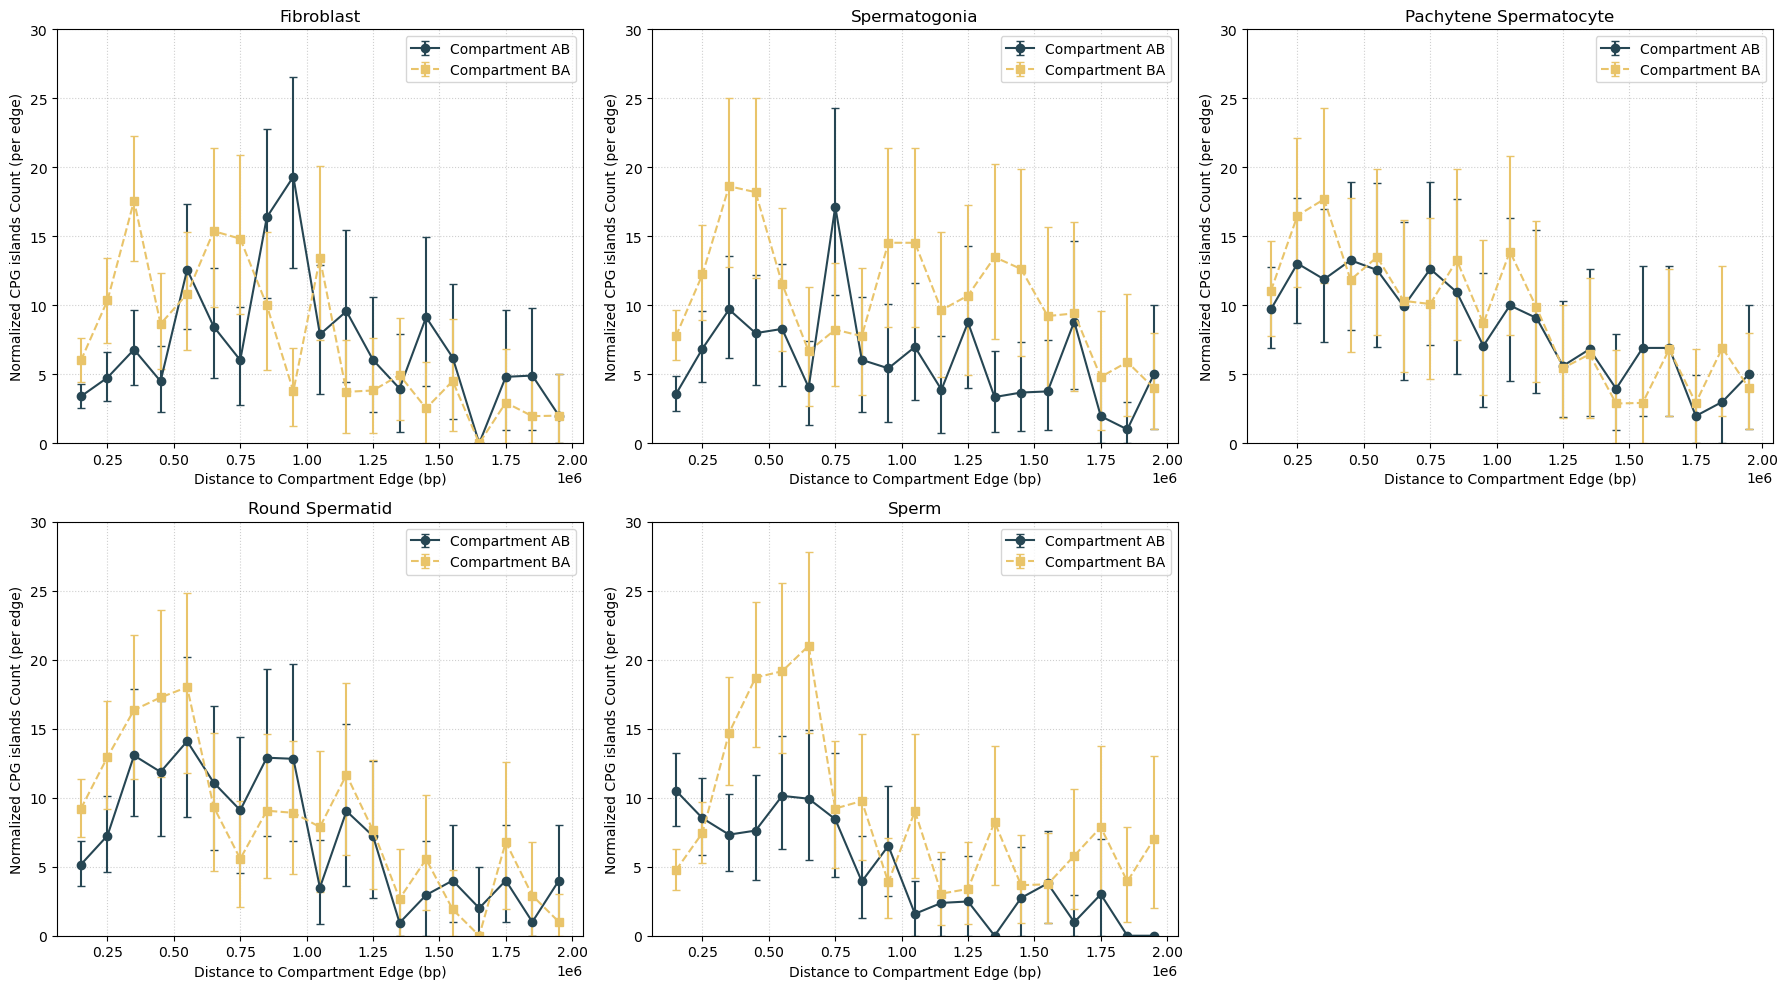

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.stats as stats

# A_color = "#264653"  # Indigo
# B_color = "#E9C46A"  # Coral

# # Desired plotting order (must match keys in remapped_data)
# order = [
#     "fibroblast_e1_100kb_10Mb_edges",
#     "spermatogonia_e1_100kb_10Mb_edges",
#     "pachytene_spermatocyte_e1_100kb_10Mb_edges",
#     "round_spermatid_e1_100kb_10Mb_edges",
#     "sperm_e1_100kb_10Mb_edges",
# ]

# # Plot settings
# num_bins = 20
# max_dist = 2_000_000
# bins = np.linspace(0, max_dist, num_bins + 1)
# bin_centers = 0.5 * (bins[:-1] + bins[1:])


# def bin_absmid_with_poisson_CI(absmid_values, bins, cumulative_fraction, max_dist):
#     counts, _ = np.histogram(absmid_values, bins=bins)
#     expected = np.where(counts <= 0, 1e-10, counts)  # avoid zeros for CI
#     lower, upper = stats.poisson.interval(0.95, expected)
#     lower_error = np.maximum(expected - lower, 0)
#     upper_error = np.maximum(upper - expected, 0)
#     return counts, np.vstack([lower_error, upper_error])

# # Grid
# fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# axes = np.array(axes).flatten()

# plot_idx = 0
# for sample in order:
#     # Skip if sample or its edge table is missing
#     if sample not in remapped_data:
#         print(f"Warning: {sample} not in remapped_data, skipping...")
#         continue
#     edge_key = f"{sample}_AB"
#     if edge_key not in globals():
#         print(f"Warning: {edge_key} not found, skipping...")
#         continue
#     if plot_idx >= len(axes):
#         break

#     pair = remapped_data[sample]
#     A_df = pair["A"]
#     B_df = pair["B"]

#     edge_df = globals()[edge_key]
#     result_A, result_B = bin_half_distances_by_compartment(edge_df)

#     counts_A, raw_errors_A = bin_absmid_with_poisson_CI(
#         A_df['absmid'].dropna().values, bins, result_A["cumulative_fraction"], max_dist
#     )
#     counts_B, raw_errors_B = bin_absmid_with_poisson_CI(
#         B_df['absmid'].dropna().values, bins, result_B["cumulative_fraction"], max_dist
#     )

#     # Normalize by cumulative fractions (avoid zeros)
#     norm_cumulative_A = np.where(result_A["cumulative_fraction"] == 0, np.nan, result_A["cumulative_fraction"])
#     norm_cumulative_B = np.where(result_B["cumulative_fraction"] == 0, np.nan, result_B["cumulative_fraction"])

#     norm_counts_A = counts_A * norm_cumulative_A
#     norm_counts_B = counts_B * norm_cumulative_B
#     norm_errors_A = raw_errors_A * norm_cumulative_A
#     norm_errors_B = raw_errors_B * norm_cumulative_B

#     ax = axes[plot_idx]
#     ax.errorbar(bin_centers, norm_counts_A, yerr=norm_errors_A,
#                 marker='o', linestyle='-', capsize=3, label='Compartment AB', color=A_color)
#     ax.errorbar(bin_centers, norm_counts_B, yerr=norm_errors_B,
#                 marker='s', linestyle='--', capsize=3, label='Compartment BA', color=B_color)

#     clean_title = sample.replace("_e1_100kb_10Mb_edges", "").replace("_", " ").title()
#     ax.set_title(clean_title)
#     ax.set_xlabel("Distance to Compartment Edge (bp)")
#     ax.set_ylabel("Normalized CPG islands Count (per edge)")
#     ax.grid(True, linestyle=":", alpha=0.6)
#     ax.legend()
#     ax.set_ylim(0, 30)

#     plot_idx += 1

# # Hide any unused subplots
# for i in range(plot_idx, len(axes)):
#     axes[i].axis('off')

# plt.tight_layout()
# plt.savefig("/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/manuscript/illustrations/CPG_islands_chrx_normalized_poisson_CI_AB_BA.png", dpi=300)
# plt.show()


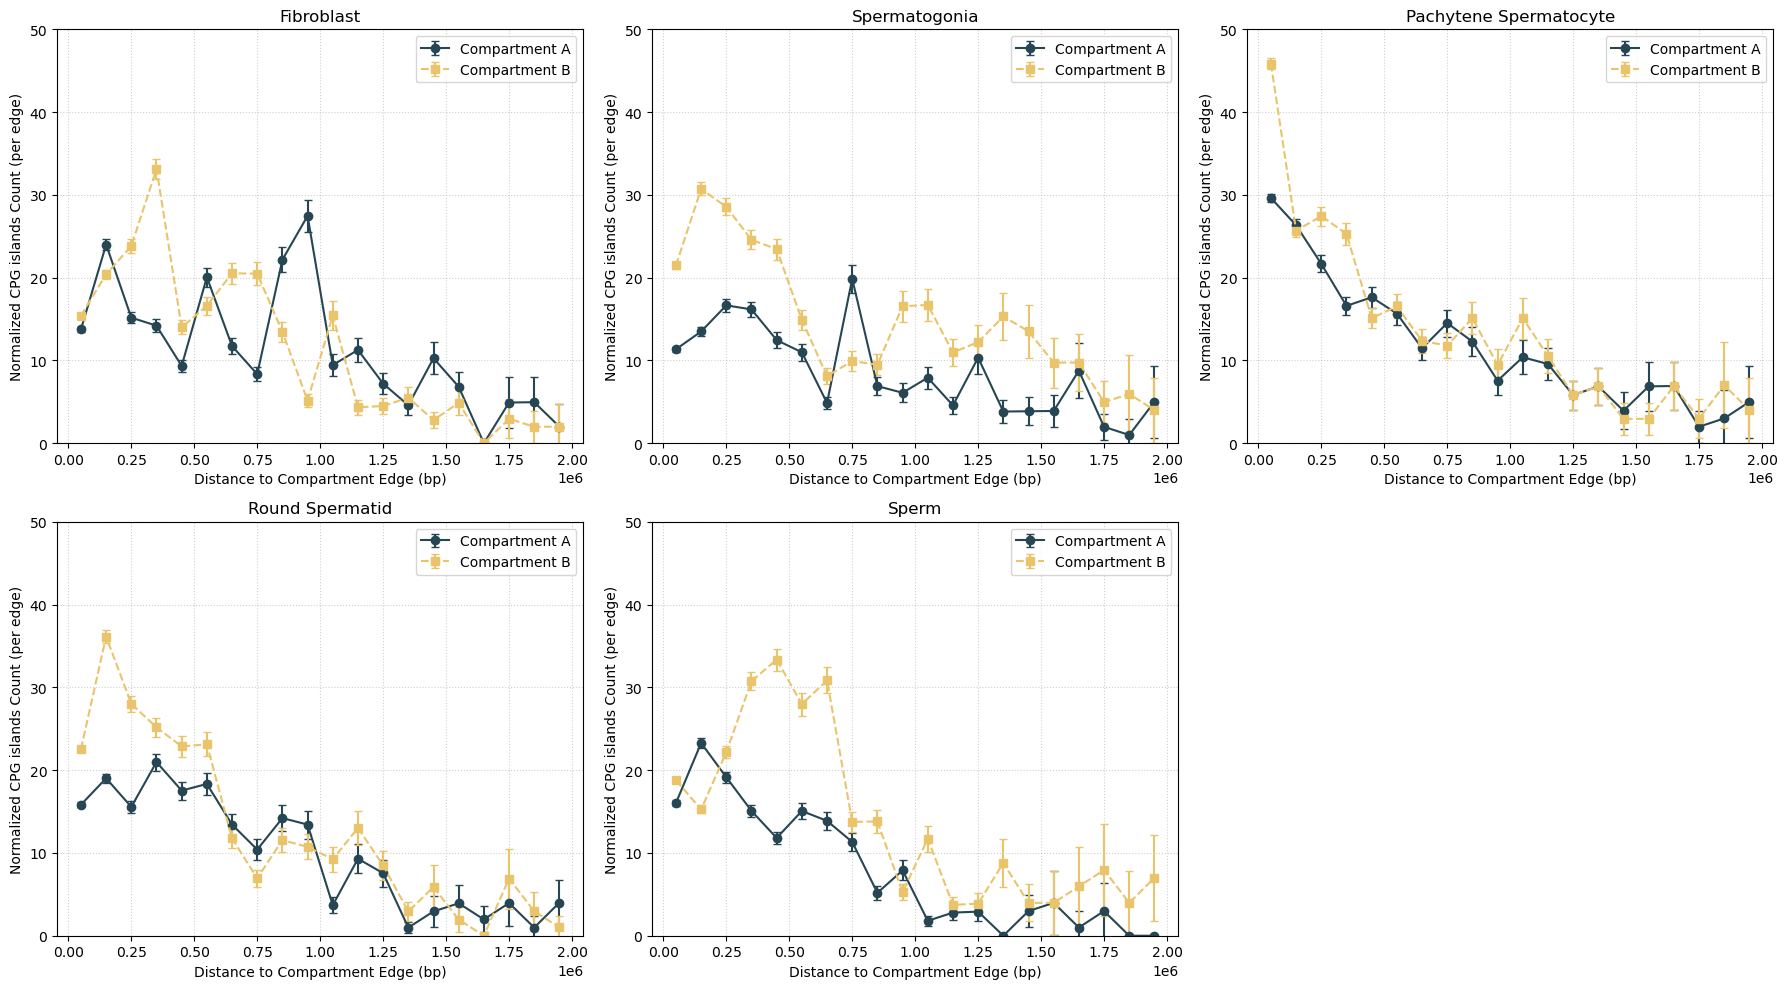

In [60]:
import numpy as np
import matplotlib.pyplot as plt

A_color = "#264653"  # Indigo
B_color = "#E9C46A"  # Coral

# Desired plotting order (must match keys in remapped_data)
order = [
    "fibroblast_e1_100kb_10Mb_edges",
    "spermatogonia_e1_100kb_10Mb_edges",
    "pachytene_spermatocyte_e1_100kb_10Mb_edges",
    "round_spermatid_e1_100kb_10Mb_edges",
    "sperm_e1_100kb_10Mb_edges",
]

# Plot settings
num_bins = 20
max_dist = 2_000_000
bins = np.linspace(0, max_dist, num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# ---- same helper as your "code above" (single combined result) ----
def bin_half_distances_by_compartment(comp, max_dist=2_000_000, bins=num_bins):
    """
    Bin half-distances between consecutive 'start' positions,
    ignoring compartments (A/B) and returning a single result
    with counts, cumulative_fraction, reverse_cumulative_fraction, reverse_cumulative.
    """
    bin_edges = np.linspace(0, max_dist, bins + 1)

    start = comp['start'].values
    if len(start) < 2:
        counts = np.zeros(bins, dtype=int)
    else:
        half_distances = [(start[i+1] - start[i]) / 2 for i in range(len(start) - 1)]
        counts, _ = np.histogram(half_distances, bins=bin_edges)

    total = np.sum(counts)
    if total > 0:
        cumulative_fraction = np.cumsum(counts) / total
        reverse_cumulative_fraction = np.cumsum(counts[::-1])[::-1] / total
    else:
        cumulative_fraction = np.zeros(bins)
        reverse_cumulative_fraction = np.zeros(bins)

    reverse_cumulative = np.cumsum(counts[::-1])[::-1]

    return {
        "counts": counts,
        "cumulative_fraction": cumulative_fraction,
        "reverse_cumulative_fraction": reverse_cumulative_fraction,
        "reverse_cumulative": reverse_cumulative
    }

# ---- error bars: same as your first script (95% CI via 1.96 * sqrt(count / n_possible)) ----
def bin_absmid_with_sd95(absmid_values, bins, reverse_cumulative):
    counts, _ = np.histogram(absmid_values, bins=bins)
    with np.errstate(divide='ignore', invalid='ignore'):
        se = np.sqrt(counts / np.maximum(reverse_cumulative, 1))
        se[np.isnan(se)] = 0.0
    errors_95 = 1.96 * se
    return counts, errors_95

# Grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = np.array(axes).flatten()

plot_idx = 0
for sample in order:
    # Skip if sample or its edge table is missing
    if sample not in remapped_data:
        print(f"Warning: {sample} not in remapped_data, skipping...")
        continue

    edge_key = f"{sample}_AB"
    if edge_key not in globals():
        print(f"Warning: {edge_key} not found, skipping...")
        continue

    if plot_idx >= len(axes):
        break

    pair = remapped_data[sample]
    A_df = pair["A"]
    B_df = pair["B"]

    # availability / normalization curve from the edge distances (single combined result)
    edge_df = globals()[edge_key]
    result = bin_half_distances_by_compartment(edge_df, max_dist=max_dist, bins=num_bins)

    # counts + 95% CI errors for A/B using SAME reverse_cumulative
    counts_A, errors_A = bin_absmid_with_sd95(
        A_df['absmid'].dropna().values, bins, result["reverse_cumulative"]
    )
    counts_B, errors_B = bin_absmid_with_sd95(
        B_df['absmid'].dropna().values, bins, result["reverse_cumulative"]
    )

    # Normalize by cumulative fractions (avoid zeros -> NaN to drop visually)
    norm_cumulative = np.where(result["cumulative_fraction"] == 0,
                               np.nan, result["cumulative_fraction"])

    norm_counts_A = counts_A * norm_cumulative
    norm_counts_B = counts_B * norm_cumulative
    norm_errors_A = errors_A * norm_cumulative
    norm_errors_B = errors_B * norm_cumulative

    ax = axes[plot_idx]
    ax.errorbar(bin_centers, norm_counts_A, yerr=norm_errors_A,
                marker='o', linestyle='-', capsize=3, label='Compartment A', color=A_color)
    ax.errorbar(bin_centers, norm_counts_B, yerr=norm_errors_B,
                marker='s', linestyle='--', capsize=3, label='Compartment B', color=B_color)

    clean_title = sample.replace("_e1_100kb_10Mb_edges", "").replace("_", " ").title()
    ax.set_title(clean_title)
    ax.set_xlabel("Distance to Compartment Edge (bp)")
    ax.set_ylabel("Normalized CPG islands Count (per edge)")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()
    ax.set_ylim(0, 50)

    plot_idx += 1

# Hide any unused subplots
for i in range(plot_idx, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(
    "/home/johanulstrup/johan_gpn/people/johanulsrup/johan_gpn/manuscript/illustrations/CPG_islands_chrx_normalized_sd95_AB_BA.png",
    dpi=300
)
plt.show()


## notes for cpg islands

CpG islands, which are typically unmethylated and associated with gene promoters, play a pivotal role in chromatin accessibility and 3D genome organization. Multiple studies have demonstrated that chromatin compartment transitions (A to B or vice versa) can be driven or accompanied by changes in CpG island methylation, histone modifications, or chromatin-binding proteins. These changes are often observed in development, cancer progression, X-chromosome inactivation, and transcriptional regulation. CGIs frequently serve as anchors or boundaries for chromatin domains and their epigenetic status can correlate with large-scale compartment reorganization, particularly between transcriptionally active A compartments and repressive B compartments.

### artikler
Reprogramming of Meiotic Chromatin Architecture during Spermatogenesis (6)
Key Findings Summary
This paper investigates how 3D chromatin architecture is reorganized during spermatogenesis—specifically in rhesus monkey and mouse models—using low-input Hi-C (a chromosome conformation capture method).

Major Contributions:
Loss and Re-establishment of TADs (Topologically Associating Domains):

During meiosis, particularly in pachytene spermatocytes, most canonical TADs dissolve even though transcription continues. This suggests that TAD structure is not strictly required for active gene expression at this stage.

Emergence of Refined Local A/B Compartments:

- Instead of standard large-scale A/B compartmentalization, fine-grained compartmental structures emerge. These “refined-A/B compartments” alternate between transcriptionally active and inactive domains.

- hese compartments are smaller, and their emergence implies a compartmental organization decoupled from transcription activity.- 

Synaptonemal Complex Dependency:

- These refined compartments require a functional synaptonemal complex (SC). In SC-defective mutants, canonical TADs are restored, suggesting that the SC actively suppresses TADs while enabling fine-scale compartmentalization.

- This is a novel role for the SC in 3D genome reorganization, beyond its known mechanical role in chromosome pairing and crossover formation.

Conservation Across Species:

- The unique meiotic chromatin organization found in rhesus monkeys is conserved in mice, suggesting this is a mammalian-wide regulatory principle during gametogenesis.


##### Implication for CpG Islands:
While CpG islands (CGIs) are not the primary focus of this paper, the study supports the broader hypothesis that CGIs may serve as boundary or anchoring elements in fine-scale compartment formation during meiosis:

The refined-A/B structure shows domain transitions that correlate with transcription activity, a feature often influenced by CGI presence at promoter regions.

Since CGIs are associated with active transcription start sites, they likely anchor boundaries between alternating compartments, effectively contributing to local chromatin insulation or regulation.

@article{Wang2019,
  year = {2019},
  title = {{Reprogramming of Meiotic Chromatin Architecture during Spermatogenesis}},
  author = {Wang, Yu and Wang, Hui and Zhang, Yixiao and Du, Zheng and Si, Wei and Fan, Shuhan and Qin, Dong and Liu, Yuliang and Liu, Yuhan and Xu, Shiyuan and others},
  journal = {Molecular Cell},
  issn = {1097-4164},
  doi = {10.1016/j.molcel.2018.11.019},
  abstract = {{Chromatin organization undergoes drastic reconfiguration during gametogenesis. However, the molecular reprogramming of three-dimensional chromatin structure in this process remains poorly understood for mammals, including primates. Here, we examined three-dimensional chromatin architecture during spermatogenesis in rhesus monkey using low-input Hi-C. Interestingly, we found that topologically associating domains (TADs) undergo dissolution and reestablishment in spermatogenesis. Strikingly, pachytene spermatocytes, where synapsis occurs, are strongly depleted for TADs despite their active transcription state but uniquely show highly refined local compartments that alternate between transcribing and non-transcribing regions (refined-A/B). Importantly, such chromatin organization is conserved in mouse, where it remains largely intact upon transcription inhibition. Instead, it is attenuated in mutant spermatocytes, where the synaptonemal complex failed to be established. Intriguingly, this is accompanied by the restoration of TADs, suggesting that the synaptonemal complex may restrict TADs and promote local compartments. Thus, these data revealed extensive reprogramming of higher-order meiotic chromatin architecture during mammalian gametogenesis.}},
  volume = {73},
  number = {3},
  pages = {547--561.e6},
  pmid = {30686580},
  local-url = {https://www.cell.com/molecular-cell/fulltext/S1097-2765(18)30989-4}
}



##### maybe  relevant articles:

Reconstructing A/B compartments as revealed by Hi-C using long-range correlations in epigenetic data (3)

Smchd1-Dependent and -Independent Pathways Determine Developmental Dynamics of CpG Island Methylation on the Inactive X Chromosome (4)